In [1]:
# import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import networkx as nx
import random
import sys
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


from pretopologic.netgenerator.geometric import network_ball_distances
from pretopologic.space.pretopological_space import PretopologicalSpace, Prenetwork
from pretopologic.structure.closures import elementary_closures_shortest_degree
from pretopologic.structure.hierarchy import Pseudohierarchy
from pretopologic.netgenerator.geometric import areaminmax, area, diff

In [2]:
np.set_printoptions(threshold=sys.maxsize)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def dnf_to_text(dnf, features=['POSITION', 'SIZE', 'SHAPE', 'TIME SERIES']):
    """Function to display the DNF used to calculate the pseudohierarchy"""
    text = ''
    for i, ors in enumerate(dnf):
        if i > 0:
            text += " OR "
        for j, ands in enumerate(ors):
            if j > 0:
                text += " AND "
            text += features[ands]
    return text

Les différentes methode de calcul de distances

In [5]:
# ON DETERMINE DES FONCTIONS DE CALCUL D'UNE DISTANCE ENTRE DES SERIES TEMPORELLES
# Here we use spearman correlation
def pearson(x, y):
    print(f"x: {x}")
    print(f"type(x): {type(x)}")
    r = sp.stats.pearsonr(x, y)[0]
    return (1 - r)  # correlation to distance: range 0 to 2

def dtw_distance(x, y):
    distance, _ = fastdtw(x, y)
    return distance

# definition des fonctions:
def time_series_distance_matrix(df_time_series, methode=pearson):
    sensors_nb = len(df_time_series)
    dm = np.ndarray(shape=(sensors_nb, sensors_nb), dtype=float)
    # # print(dm)
    for i in range(sensors_nb):
        for j in range(sensors_nb):
            dm[i, j] = methode(df_time_series.iloc[i], df_time_series.iloc[j])
    return dm

In [6]:
def qualitative(x, y):
    #print(f"x == y: {x} == {y}")
    #print(f"x.iloc[0] == y.iloc[0]: {x.iloc[0]} == {y.iloc[0]}")
    #print(pd.Series([int(x==y)]))
    # print(f"type of x: {type(x[0])}")
    # print(f" x: {x[0]}, y: {y[0]}")
    # print(f"the distance between {x} and {y} is: {[int(x == y)*10+random.uniform(0,4)]}")
    # print(type(pd.Series([int(x == y)*10+random.uniform(0,2)])))
    return pd.Series([int(x != y)])
    # return abs(x - y)

In [7]:
def diff2(x, y):
    # print(f"abs(x - y):{abs(x - y)}")
    # print(f"abs(x - y):{abs(x - y)}")
    # print(type(abs(x - y)))
    return abs(x - y)

In [8]:
def generate_time_series(n, l, c, standard_deviation_of_clusters=1.0):
    if c > n:
        raise ValueError("Number of clusters (c) must be less than or equal to the number of time series (n)")

    # Generate random cluster centers
    cluster_centers = np.random.randn(c, l)
    
    # Generate sinuzoidal cluster centers
    cluster_centers = []
    for _ in range(c):
        a = np.random.randint(1, 100)
        b = np.random.randint(1, 100)
        c_coeff = np.random.randint(1, 10)
        d = np.random.randint(1, 100)
        x = np.linspace(0, 4 * np.pi, l)
        cluster_center = d + np.cos(a * x + b) * c_coeff
        cluster_centers.append(cluster_center)
    cluster_centers = np.array(cluster_centers)

    # Generate time series dataset and cluster labels
    time_series_data = []
    cluster_labels = []
    for _ in range(n):
        # Choose a random cluster center
        cluster_idx = np.random.randint(0, c)
        cluster_center = cluster_centers[cluster_idx]        

        # Generate a time series from the chosen cluster center with added Gaussian noise
        time_series = cluster_center + np.random.normal(0, standard_deviation_of_clusters, l)
        time_series_data.append(time_series)
        cluster_labels.append(cluster_idx)

    return pd.DataFrame(time_series_data), np.array(cluster_labels)


def dtw_distance_matrix(time_series_data):
    n = len(time_series_data)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            distance, _ = fastdtw(time_series_data[i], time_series_data[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

    return distance_matrix


def plot_time_series_true_clusters(time_series_data, cluster_labels):
    time_series_data = time_series_data.to_numpy()  # Convert DataFrame to numpy array
    unique_labels = np.unique(cluster_labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        idx = cluster_labels == label
        for ts in time_series_data[idx]:
            plt.plot(ts, color=color, alpha=0.5)

    plt.title("Generated Time Series Clusters")
    plt.show()

In [9]:
def create_test_set(num_samples=61, group_size=30, num_groups=6):
    #
    # create the main time series for each group
    #

    x = np.linspace(0, 5, num_samples)
    scale = 4

    a = scale * np.sin(x)
    b = scale * (np.cos(1 + x * 3) + np.linspace(0, 1, num_samples))
    c = scale * (np.sin(2 + x * 6) + np.linspace(0, -1, num_samples))
    d = scale * (np.cos(3 + x * 9) + np.linspace(0, 4, num_samples))
    e = scale * (np.sin(4 + x * 12) + np.linspace(0, -4, num_samples))
    f = scale * np.cos(x)

    #
    # from each main series build 'group_size' series
    #
    sets = [a, b, c, d, e, f]
    timeSeries = pd.DataFrame()
    ax = None
    for i in range(num_groups):
        arr = sets[i]
        arr = arr + np.random.rand(group_size, num_samples) + np.random.randn(group_size, 1)
        df = pd.DataFrame(arr)
        timeSeries = timeSeries.append(df)

    df_time_series_sample = timeSeries
    # print("time series: ", timeSeries)
    return df_time_series_sample

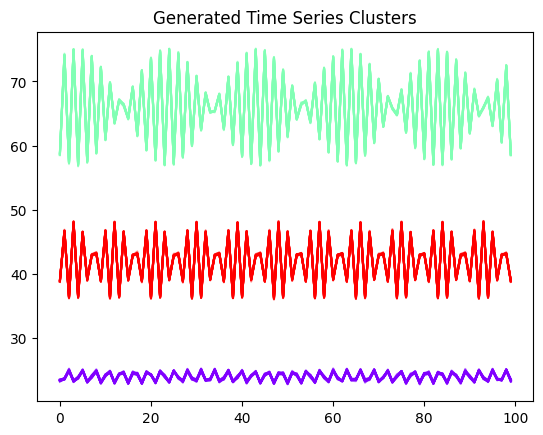

In [10]:
n = 50
l = 100
c = 3
standard_deviation_of_clusters = 0.1

time_series_data, cluster_labels = generate_time_series(n, l, c, standard_deviation_of_clusters)
distance_matrix = dtw_distance_matrix(time_series_data)
plot_time_series_true_clusters(time_series_data, cluster_labels)

In [11]:
def hierarchy_pos(G, root=None, width=50., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [12]:
def make_tree(adjacency_matrix):
    tree = []
    matrix_len = len(adjacency_matrix)
    for i in range(len(adjacency_matrix) - 1):
        j = i + 1
        done = True
        while j < matrix_len and done == True:
            if adjacency_matrix[i,j] == 1:
                tree.extend([(i, j)])
                done = False
            elif j == matrix_len - 1:
                tree.extend([(i, -1)])
                done = False
            else:
                j += 1
    tree.extend([(matrix_len - 1, -1)])
    return tree

In [13]:
def plot_pseudohierarchy(pseudohierarchy):
    size = len(pseudohierarchy.l_selected_sets)
    l_size_selected_sets = [sum(pseudohierarchy.l_selected_sets[i]) for i in range(size)]
    l_rank_of_sets = [sum(pseudohierarchy.adjacency_matrix[i])-1 for i in range(size)]
    print('l_rank_of_sets: ', l_rank_of_sets)
    
    

In [14]:
def plot_clusters(clusterable_data, pseudohierarchie, param2, param3, size):
    labels = np.zeros(len(clusterable_data))
    for i, closure in enumerate(pseudohierarchie.l_selected_sets):
        labels += (i + 1) * closure
        # # print('closure ', closure)
        # # print(labels)
        labels[labels > (i + 1)] = (i + 1)
        # # print(labels)
    labels = labels - 1
    labels = labels.astype('int')
    unique_labels = list(set(labels))
    print(labels)
    new_labels = [unique_labels.index(x) if x != -1 else x for x in labels]

    s_labels = set(labels)
    s_labels.discard(-1)
    print('nb_of_clusters:', len(s_labels))
    palette = sns.color_palette('bright', np.unique(new_labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in new_labels]
    plt.figure(figsize=size)
    for i, shape in enumerate(param3):
        plt.scatter(clusterable_data[i, 0], clusterable_data[i, 1], c=np.array([colors[i]]), s = param2[i]**2, marker=shape , alpha = 0.7)
    plt.show()
    return colors

In [15]:
def plot_time_series_clusters(clusterable_data, pseudohierarchie, size, colors=None):
    labels = np.zeros(len(clusterable_data))
    for i, closure in enumerate(pseudohierarchie.l_selected_sets):
        labels += (i+1)*closure
        # # print('closure ', closure)
        # # print(labels)
        labels[labels > (i+1)] = (i+1)
        # # print(labels)
    labels = labels - 1
    labels = labels.astype('int')
    unique_labels = list(set(labels))
#     print('labels: ', labels)
    new_labels = [unique_labels.index(x) if x!=-1 else x for x in labels]
#     print('new_labels: ', new_labels)
    clusters = list(set(new_labels))

    clusters_indexes = []
    for cluster in clusters:
        indices = [i for i, x in enumerate(new_labels) if x == cluster]
        clusters_indexes.append(indices)

#     print('clusters_indexes: ', clusters_indexes)
    if not colors:
        palette = sns.color_palette('bright', np.unique(new_labels).max() + 1)
        colors = [palette[x] + (0.1,) if x >= 0 else (0.0, 0.0, 0.0, 0.5) for x in new_labels]

    for i, indexes in enumerate(clusters_indexes):
        if not clusterable_data.iloc[indexes].empty:
            plt.plot(clusterable_data.iloc[indexes].transpose(), c=colors[i], linewidth=0.5)
    plt.savefig('clusters.png')
    plt.show()
    print('number of clusters: ', len(set(new_labels)))
    return new_labels

We initialize the data we are going to process

In [16]:
# pretopological space parameters
radius_coeff = 20
# dois être superieur à 0
threshold_coeff = 1
closest_coeff = 1
square_length_coeff = 0.1
initial_set_size = 1

In [17]:
# generates 3 clusters 
a_center = [200, 0]
b_center = [0, 100]
c_center = [100, 100]
a_size = 20
b_size = 20
c_size = 21
a_dispersion = 2
b_dispersion = 10
c_dispersion = 100000

In [18]:
# generates 3 clusters 
a_center = [200, 0]
b_center = [0, 100]
c_center = [100, 100]
a_size = 25
b_size = 15
c_size = 10
a_dispersion = 10
b_dispersion = 30
c_dispersion = 10

In [19]:
# ON CRÉER UN JEUX DE TEST
#
# build 6 time series groups for testing, called: a, b, c, d, e, f
#
def create_test_set(num_samples=61, group_size=30, num_groups=6):
    #
    # create the main time series for each group
    #

    x = np.linspace(0, 5, num_samples)
    scale = 4

    a = scale * np.sin(x)
    b = scale * (np.cos(1 + x * 3) + np.linspace(0, 1, num_samples))
    c = scale * (np.sin(2 + x * 6) + np.linspace(0, -1, num_samples))
    d = scale * (np.cos(3 + x * 9) + np.linspace(0, 4, num_samples))
    e = scale * (np.sin(4 + x * 12) + np.linspace(0, -4, num_samples))
    f = scale * np.cos(x)

    #
    # from each main series build 'group_size' series
    #
    sets = [a, b, c, d, e, f]
    timeSeries = pd.DataFrame()
    ax = None
    for i in range(num_groups):
        arr = sets[i]
        arr = arr + np.random.rand(group_size, num_samples) + np.random.randn(group_size, 1)
        df = pd.DataFrame(arr)
        timeSeries = timeSeries.append(df)

    df_time_series_sample = timeSeries
    # print("time series: ", timeSeries)
    return df_time_series_sample

In [20]:
# def plot_time_series_clusters(clusterable_data, pseudohierarchie, size):
#     clusterable_data = pd.DataFrame(clusterable_data)
#     labels = np.zeros(len(clusterable_data))
#     for i, closure in enumerate(pseudohierarchie.l_selected_sets):
#         labels += (i+1)*closure
#         # # print('closure ', closure)
#         # # print(labels)
#         labels[labels > (i+1)] = (i+1)
#         # # print(labels)
#     labels = labels - 1
#     labels = labels.astype('int')
#     unique_labels = list(set(labels))
# #     print('labels: ', labels)
#     new_labels = [unique_labels.index(x) if x!=-1 else x for x in labels]
# #     print('new_labels: ', new_labels)
#     clusters = list(set(new_labels))
# 
#     clusters_indexes = []
#     for cluster in clusters:
#         indices = [i for i, x in enumerate(new_labels) if x == cluster]
#         clusters_indexes.append(indices)
# 
# #     print('clusters_indexes: ', clusters_indexes)
# 
#     # colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']*100
# # 
#     # for i, indexes in enumerate(clusters_indexes):
#     #     if not clusterable_data.iloc[indexes].empty:
#     #         plt.plot(clusterable_data.iloc[indexes].transpose(), c=colors[i])
#     # plt.savefig('clusters.png')
#     # plt.show()
#     # print('number of clusters: ', len(set(new_labels)))
#     
#     
# #     print('new_labels:', new_labels)
# #     s_labels = set(labels)
# #     s_labels.discard(-1)
# #     print('nb_of_clusters:', len(s_labels))
# #     print('s_labels:', s_labels)
# #     clusters = list(set(s_labels))
# #     print('clusters:', clusters)
# #     clusters_indexes =  []
# #     for cluster in clusters:
# #         indices = [i for i, x in enumerate(s_labels) if x == cluster]
# #         clusters_indexes.append(indices)
# 
# #     print('clusters_indexes: ', clusters_indexes)
# 
# #     colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
# 
# #     for i, indexes in enumerate(new_labels):
# #         plt.plot(clusterable_data.iloc[indexes].transpose(), c=colors[i])
# #     plt.savefig('clusters.png')
# #     plt.show()
#     
# #     palette = sns.color_palette('bright', np.unique(new_labels).max() + 1)
# #     colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in new_labels]
# #     plt.figure(figsize=size)
#     
#     
# #     plt.scatter(clusterable_data[:, 0], clusterable_data[:, 1], c = colors, s = param2**2, alpha = 0.7)
# #     plt.show()
#     return new_labels

In [21]:
# pretopological space parameters
radius_coeff = 20
threshold_coeff = 0.1
closest_coeff = 0.5
square_length_coeff = 0.1
initial_set_size = 1

# pretopological space parameters
radius_coeff = 20
# dois être superieur à 0
threshold_coeff = 2
closest_coeff = 1
square_length_coeff = 0.1
initial_set_size = 1

In [26]:
def plot_hierarchy(a_center, b_center, c_center, a_size, b_size, c_size, a_dispersion, b_dispersion, c_dispersion,
                   radius_coeff, threshold_coeff, closest_coeff, square_length_coeff, initial_sets_size):
    # Positionnal clusters
    np.random.seed(4711)  # for repeatability of this tutorial
    a = np.random.multivariate_normal(a_center,
                                      [[1 * a_dispersion, 7 * a_dispersion], [7 * a_dispersion, 1 * a_dispersion]],
                                      size=[a_size, ])
    b = np.random.multivariate_normal(b_center,
                                      [[3 * b_dispersion, 1 * b_dispersion], [1 * b_dispersion, 3 * b_dispersion]],
                                      size=[b_size, ])
    c = np.random.multivariate_normal(c_center,
                                      [[3 * c_dispersion, 1 * c_dispersion], [2 * c_dispersion, 2 * c_dispersion]],
                                      size=[c_size, ])
    clusterable_data = np.concatenate((a, b, c), )
    df_clusterable_data = pd.DataFrame(data=clusterable_data[0:, 0:])

    # Size of shapes
    total_size = a_size + b_size + c_size
    param2a = np.random.randint(5, 8, size=total_size // 4)
    param2b = np.random.randint(18, 30, size=total_size // 2)
    param2c = np.random.randint(5, 8, size=total_size - total_size // 4 - total_size // 2)
    param2 = np.concatenate((param2a, param2b, param2c), )
    df_param2 = pd.DataFrame(data=param2)

    total_size = a_size + b_size + c_size

    print(f"total_size: {total_size}")

    # Shape of discs
    # param3 = [['^', 'o', 's'][i] for i in np.random.randint(3, size=50)]
    param3 = np.array([[0, 1, 2, 3][i] for i in np.random.randint(4, size=total_size)])
    shapes = [['^', 'o', 's', 'X'][i] for i in param3]
    df_param3 = pd.DataFrame(data=param3)

    # Time Series Dataset
    df_param4, cluster_labels = generate_time_series(n=total_size, l=100, c=3, standard_deviation_of_clusters=0.5)
    plot_time_series_true_clusters(df_param4, cluster_labels)

    # print('[int(df_param2.iloc[0]-df_param2.iloc[1])]')
    # print([int(df_param2.iloc[0]-df_param2.iloc[1])])
    # print('df_param3.iloc[0]==df_param3.iloc[1]')
    # print(int(df_param3.iloc[0]==df_param3.iloc[1]))

    prenetwork1 = Prenetwork(df_clusterable_data, sp.spatial.distance.euclidean, areaminmax, network_ball_distances,
                        radius_coeff=radius_coeff, threshold_coeff=threshold_coeff, closest_coeff=closest_coeff,
                        square_length_coeff=square_length_coeff)

    prenetwork2 = Prenetwork(df_param2, diff2, areaminmax, network_ball_distances,
                        radius_coeff=radius_coeff, threshold_coeff=threshold_coeff, closest_coeff=closest_coeff,
                        square_length_coeff=square_length_coeff*2)
    
    prenetwork3 = Prenetwork(df_param3, qualitative, areaminmax, network_ball_distances,
                       radius_coeff=radius_coeff, threshold_coeff=threshold_coeff, closest_coeff=closest_coeff,
                       square_length_coeff=square_length_coeff)
    prenetwork4 = Prenetwork(df_param4, dtw_distance, area, network_ball_distances, radius_coeff=radius_coeff,
                             threshold_coeff=threshold_coeff, closest_coeff=closest_coeff,
                             square_length_coeff=square_length_coeff)

    print(f"prenetwork4.size: {prenetwork4.size}")

    pre_space1 = PretopologicalSpace([prenetwork1], [[0]])
    closures_list1 = elementary_closures_shortest_degree(pre_space1, initial_sets_size)
    
    pre_space2 = PretopologicalSpace([prenetwork2], [[0]])
    closures_list2 = elementary_closures_shortest_degree(pre_space2, initial_sets_size)
    
    pre_space3 = PretopologicalSpace([prenetwork3], [[0]])
    closures_list3 = elementary_closures_shortest_degree(pre_space3, initial_sets_size)

    pre_space4 = PretopologicalSpace([prenetwork4], [[0]])
    closures_list4 = elementary_closures_shortest_degree(pre_space4, initial_sets_size)

    pre_space_total = PretopologicalSpace([prenetwork1, prenetwork2, prenetwork3, prenetwork4], [[0, 2, 3], [1, 3]])
    closures_list_total = elementary_closures_shortest_degree(pre_space_total, initial_sets_size)
    #
    pseudohierarchie1 = Pseudohierarchy(closures_list1.copy(),)
    pseudohierarchie2 = Pseudohierarchy(closures_list2.copy(),)
    pseudohierarchie3 = Pseudohierarchy(closures_list3.copy(),)
    pseudohierarchie4 = Pseudohierarchy(closures_list4.copy(), )
    pseudohierarchie_total = Pseudohierarchy(closures_list_total.copy(), )

    print('     POSTION')
    # print('data:', df_clusterable_data)
    print('nb elements:', len(prenetwork1.dm))
    print('dm: ', prenetwork1.dm[0][:5])
    print('square_length: ', prenetwork1.square_length)
    print('closest: ', prenetwork1.closest[:10])
    print('radius: ', prenetwork1.radius)
    print('threshold: ', prenetwork1.thresholds[0])
    print('formatted_network: ', prenetwork1._formatted_network[0][:10])
    plot_clusters(clusterable_data, pseudohierarchie1, param2, shapes, (20, 6))
    print('     SIZE')
    print('nb elements:', len(prenetwork2.dm))
    print('dm: ', prenetwork2.dm[0][:10])
    print('square_length: ', prenetwork2.square_length)
    print('closest: ', prenetwork2.closest[:10])
    print('radius: ', prenetwork2.radius)
    print('threshold: ', prenetwork2.thresholds[0])
    print('formatted_network: ', prenetwork2._formatted_network[0][:10])
    plot_clusters(clusterable_data, pseudohierarchie2, param2, shapes, (20,6))
    print('     SHAPE')
    print('dm: ', prenetwork3.dm[0][:10])
    print('square_length: ', prenetwork3.square_length)
    print('closest: ', prenetwork3.closest[:10])
    print('radius: ', prenetwork3.radius)
    print('threshold: ', prenetwork3.thresholds[0])
    print('formatted_network: ', prenetwork3._formatted_network[0][:10])
    plot_clusters(clusterable_data, pseudohierarchie3, param2, shapes, (20,6))
    print('     TIME SERIES')
    print('dm: ', prenetwork4.dm[0][:])
    print('square_length: ', prenetwork4.square_length)
    print('closest: ', prenetwork4.closest[:10])
    print('radius: ', prenetwork4.radius)
    print('threshold: ', prenetwork4.thresholds[0])
    print('formatted_network: ', prenetwork4._formatted_network[0][:10])
    plot_time_series_clusters(df_param4, pseudohierarchie4, (20, 6))

    print('     ' + dnf_to_text(pre_space_total.dnf, features=['POSITION', 'SIZE', 'SHAPE', 'TIME SERIES']))
    colors = plot_clusters(clusterable_data, pseudohierarchie_total, param2, shapes, (20, 6))
    plot_time_series_clusters(df_param4, pseudohierarchie_total, (20, 6))
    # print(pseudohierarchie4.adjacency_matrix)
    G = nx.Graph()
    G.add_edges_from(make_tree(pseudohierarchie_total.adjacency_matrix))
    pos = hierarchy_pos(G, -1, width=50.)
    nx.draw(G, pos=pos, with_labels=True)
    # # plt.savefig('hierarchy.png')
    plt.show()
    print('     ' + dnf_to_text(pre_space_total.dnf, features=['POSITION', 'SIZE', 'SHAPE', 'TIME SERIES']) + ' SUBSETS')
    plot_pseudohierarchy(pseudohierarchie_total)
    for i in range(len(pseudohierarchie_total.l_selected_sets)):
        nb_of_points = int(sum(pseudohierarchie_total.l_selected_sets[i]))
        if nb_of_points > 0:
            print(pseudohierarchie_total.l_selected_sets[i])
            parent_cluster = [j for j in range(i + 1, len(pseudohierarchie_total.l_selected_sets)) if
                              pseudohierarchie_total.adjacency_matrix[i][j] == 1]
            if parent_cluster:
                print(i, ' is a subcluster of ', parent_cluster)
            else:
                print(i, 'is a cluster')
            colors = [['k', 'r'][int(j)] for j in pseudohierarchie_total.l_selected_sets[i]]
            plt.figure(figsize=(20, 6))
            for j, shape in enumerate(shapes):
                plt.scatter(clusterable_data[j, 0], clusterable_data[j, 1], c=np.array([colors[j]]), s=param2[j] ** 2,
                            marker=shape, alpha=0.5)
            print('number of points: ', nb_of_points)
            plt.show()

        nb_of_points = int(sum(pseudohierarchie_total.l_selected_sets[i]))
        if nb_of_points > 1:
            print('l_selected_sets[i]: ', pseudohierarchie_total.l_selected_sets[i])
            print(i, ' is inside ', [j for j in range(i + 4, len(pseudohierarchie_total.l_selected_sets)) if
                                     pseudohierarchie_total.adjacency_matrix[i][j] == 4])

            clusters = list(set(pseudohierarchie_total.l_selected_sets[i]))

            clusters_indexes = []
            for cluster in clusters:
                indices = [i for i, x in enumerate(pseudohierarchie_total.l_selected_sets[i]) if x == cluster]
                clusters_indexes.append(indices)

            print('clusters_indexes: ', clusters_indexes)

            colors = ['k', 'r']
            alphas = [0.05, 0.2]

            for j, indexes in enumerate(clusters_indexes):
                if not df_param4.iloc[indexes].empty:
                    plt.plot(df_param4.iloc[indexes].transpose(), c=colors[j], alpha=alphas[j])            #             plt.savefig('clusters.png')
            print('number of points: ', nb_of_points)
            plt.show()

total_size: 50


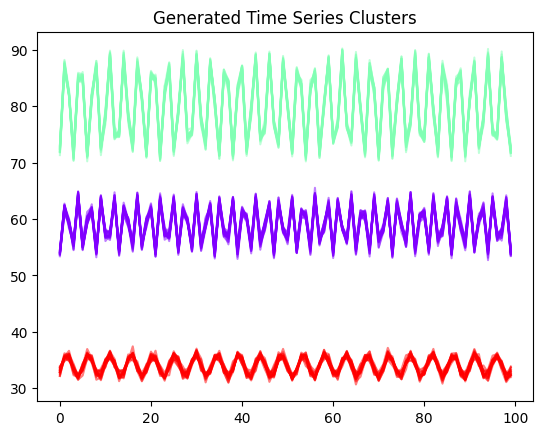

prenetwork4.size: 50
We count the elements closer to eachother than 2.4770958793127034
dm= [  0.           1.62905783  14.47963069   8.48982205  27.6072214
  14.71947519   5.25453245  18.53254966   1.93757759  12.9818379
  14.86750394   4.82366299   6.42507404  15.48166714   8.36453747
   3.16590261  15.56122899  11.39891842  11.00746605   9.03089466
  14.81389138   5.83020911   6.39008347   8.28831568  16.11556592
 208.15400415 212.18625206 205.74918826 224.78792424 228.81902489
 207.73714142 227.01304802 211.30288127 221.27456016 227.91722245
 225.36823449 238.76488198 224.68384926 221.35375854 212.07783257
 151.45258399 136.22715839 134.01628344 139.17910934 135.30073762
 137.51998782 137.69714981 142.88637505 143.06420577 144.23072955]
We count the elements closer to eachother than 2.4770958793127034
dm= [  0.           1.62905783  14.47963069   8.48982205  27.6072214
  14.71947519   5.25453245  18.53254966   1.93757759  12.9818379
  14.86750394   4.82366299   6.42507404  15.481667

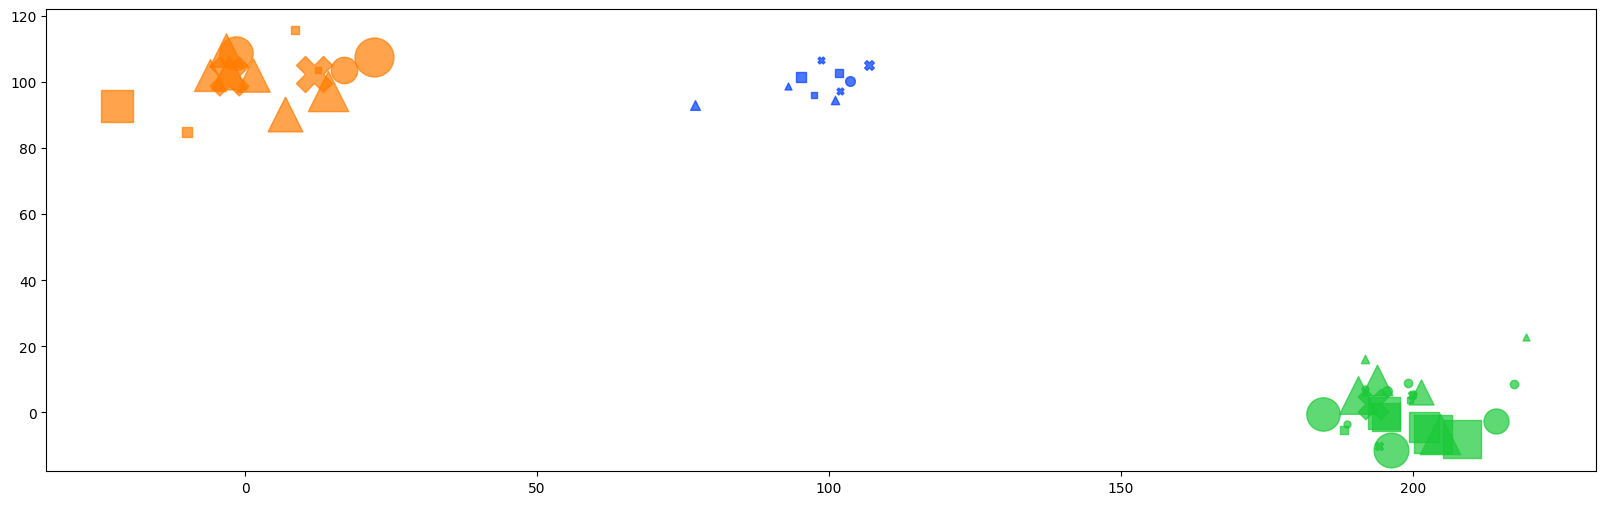

     SIZE
nb elements: 50
dm:  [0. 1. 1. 0. 0. 1. 1. 1. 0. 0.]
square_length:  0.13856406460551018
We count the elements closer to eachother than 0.13856406460551018
dm= [0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 0. 2. 2. 1. 1. 0. 2. 0. 0.
 2. 0.]
closest:  [10.  9.  9. 10. 10.  9.  9.  9. 10. 10.]
radius:  2.7712812921102037
threshold:  0.07840000000000001
formatted_network:  [1.         0.63915608 0.63915608 1.         1.         0.63915608
 0.63915608 0.63915608 1.         1.        ]
[6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 6 6 6 6 6 6 6 6 6 6 6 6 6]
nb_of_clusters: 2


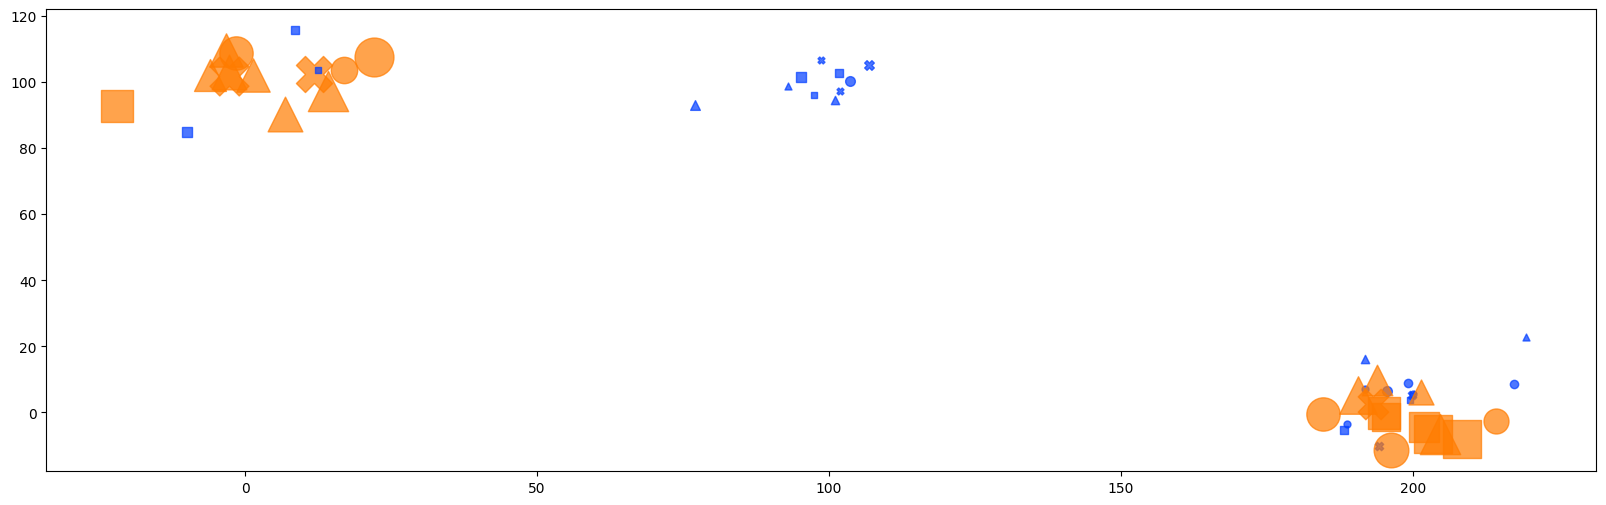

     SHAPE
dm:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
square_length:  0.024494897427831782
We count the elements closer to eachother than 0.024494897427831782
dm= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
closest:  [14.  8. 14. 13. 15. 15. 13. 13. 13. 13.]
radius:  0.48989794855663565
threshold:  0.006400000000000023
formatted_network:  [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[2 0 2 1 3 3 1 1 1 1 0 1 0 1 2 3 1 3 2 3 2 2 2 3 1 1 0 1 0 3 3 1 3 3 3 3 2
 2 2 2 3 1 3 2 0 0 2 3 2 0]
nb_of_clusters: 4


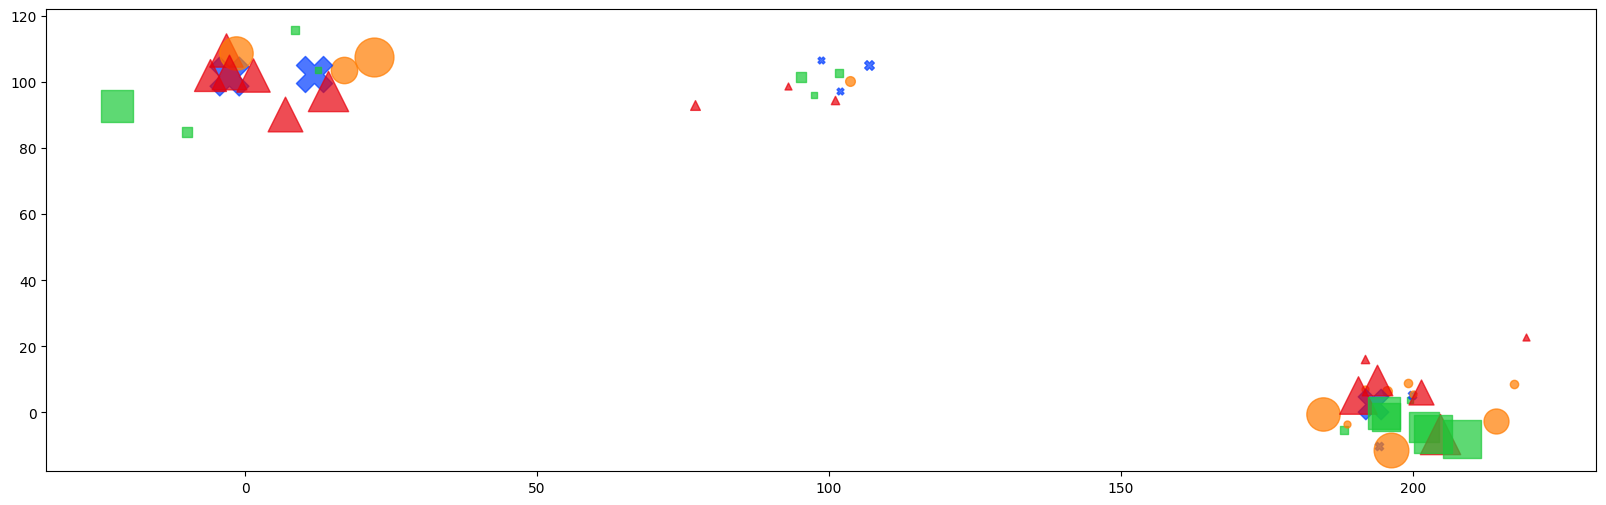

     TIME SERIES
dm:  [  0.           0.           0.           0.          50.29721588
   0.          55.91678121  52.21362074   0.           0.
  57.47827529   0.           0.          49.57897016   0.
  60.68311193 146.33857088   0.          57.22060577   0.
   0.          51.84163243   0.          48.38462928   0.
   0.          56.33103576   0.           0.           0.
   0.           0.          58.92481023   0.           0.
  57.64894624  56.48826987  57.96432276  58.13242286   0.
 143.18785973   0.           0.           0.           0.
   0.           0.           0.           0.          51.74496304]
square_length:  65.1152072382151
We count the elements closer to eachother than 65.1152072382151
dm= [  0.           0.           0.           0.          50.29721588
   0.          55.91678121  52.21362074   0.           0.
  57.47827529   0.           0.          49.57897016   0.
  60.68311193 146.33857088   0.          57.22060577   0.
   0.          51.84163243   0.         

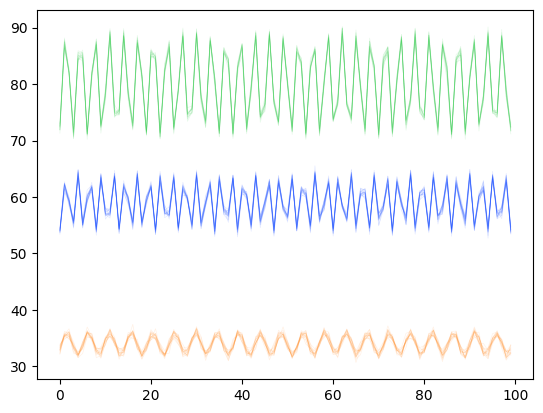

number of clusters:  3
     POSITION AND SHAPE AND TIME SERIES OR SIZE AND TIME SERIES
[24 23 20 23 24 20 24 24 20 20 24 23 23 24 23 24 24 23 24 20 23 24 20 24
 20 23 24 23 23 23 20 23 24 23 20 24 24 24 24 20 24 20 23 23 23 23 20 20
 20 24]
nb_of_clusters: 3


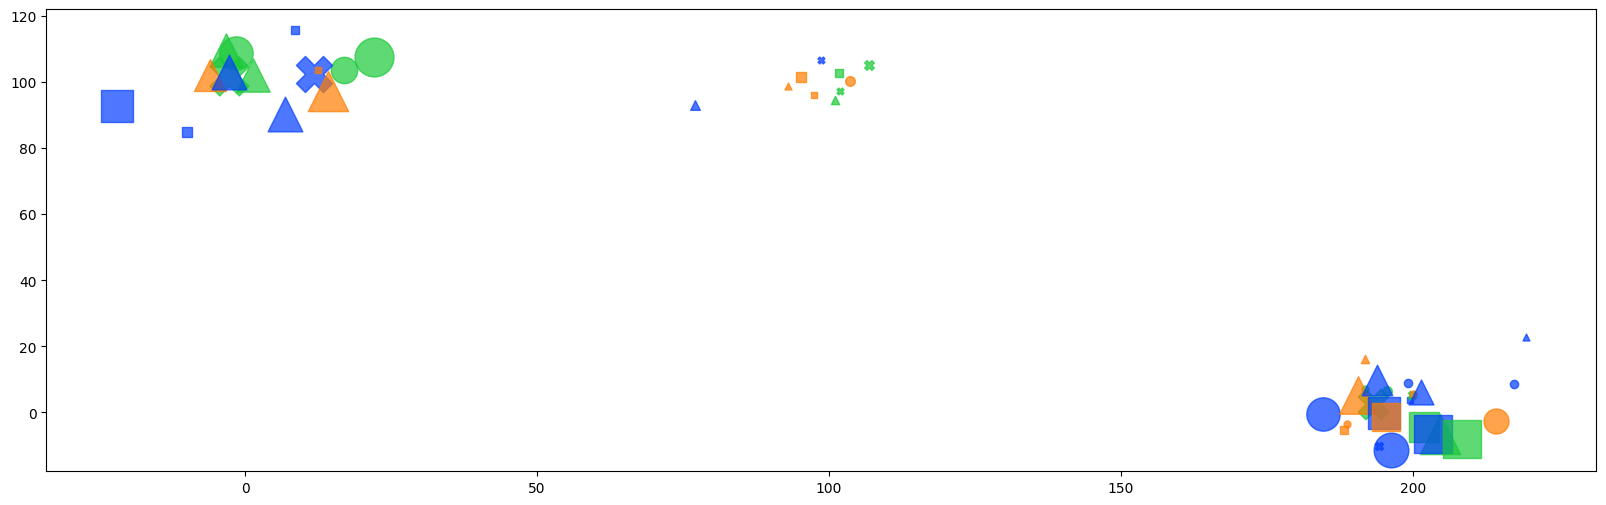

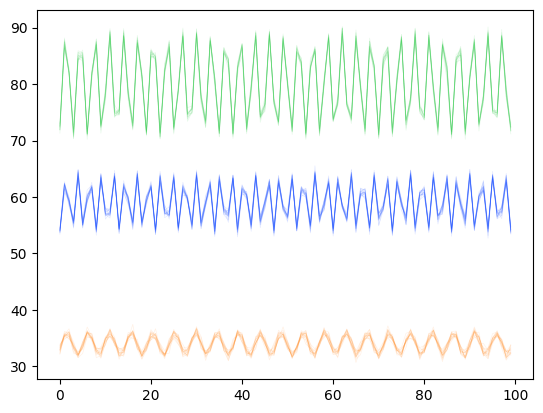

number of clusters:  3


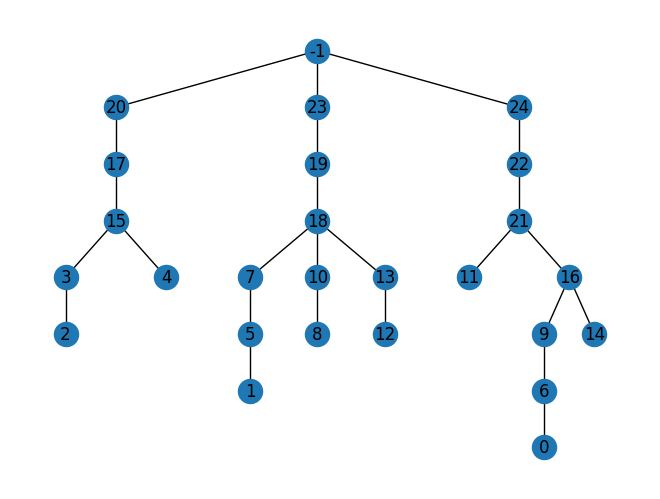

     POSITION AND SHAPE AND TIME SERIES OR SIZE AND TIME SERIES SUBSETS
l_rank_of_sets:  [5, 4, 2, 3, 3, 4, 4, 3, 4, 4, 3, 3, 4, 3, 4, 2, 3, 1, 2, 1, 0, 2, 1, 0, 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
0  is a subcluster of  [6, 9, 21, 22, 24]
number of points:  2


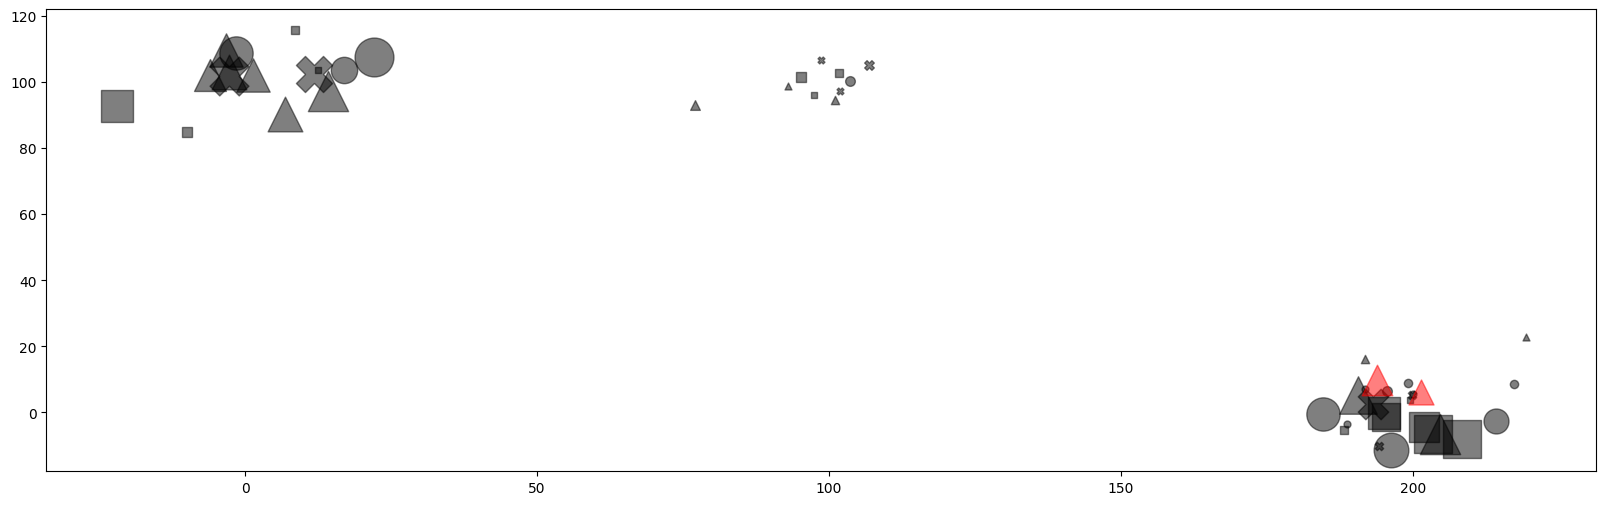

l_selected_sets[i]:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
0  is inside  []
clusters_indexes:  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [15, 23]]
number of points:  2


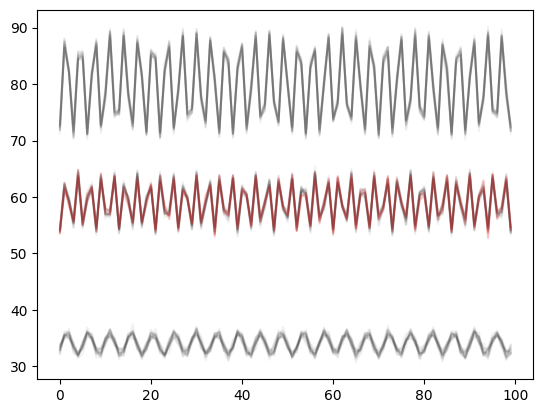

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
1  is a subcluster of  [5, 7, 19, 23]
number of points:  2


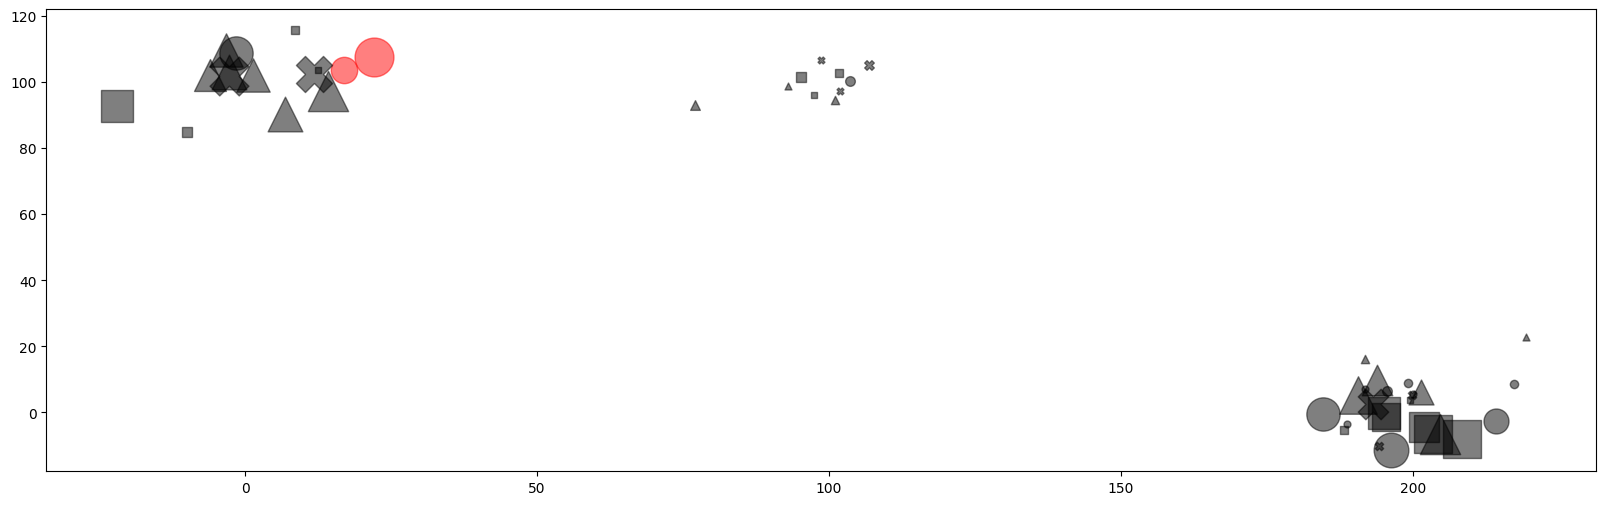

l_selected_sets[i]:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
1  is inside  []
clusters_indexes:  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [25, 27]]
number of points:  2


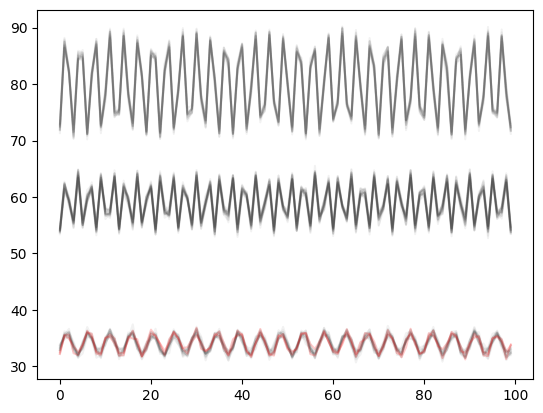

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
2  is a subcluster of  [3, 20]
number of points:  2


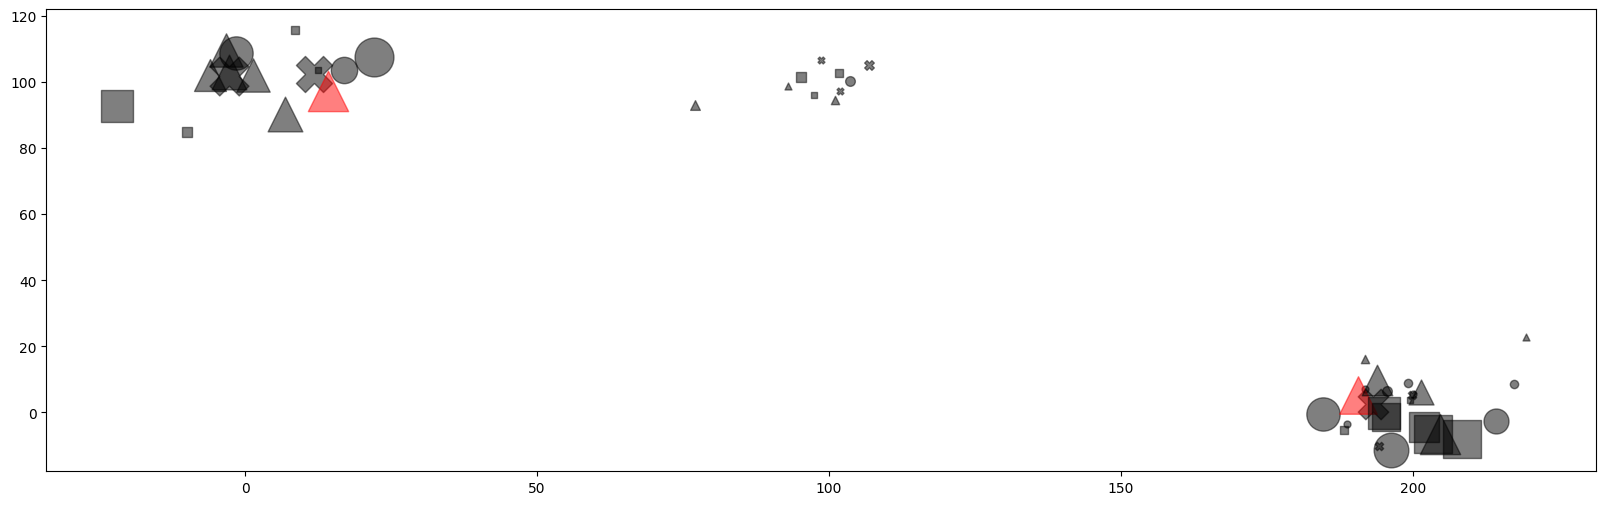

l_selected_sets[i]:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
2  is inside  []
clusters_indexes:  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [19, 30]]
number of points:  2


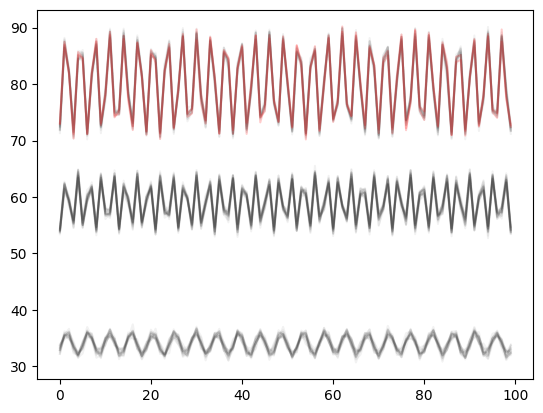

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
3  is a subcluster of  [15, 17, 20]
number of points:  3


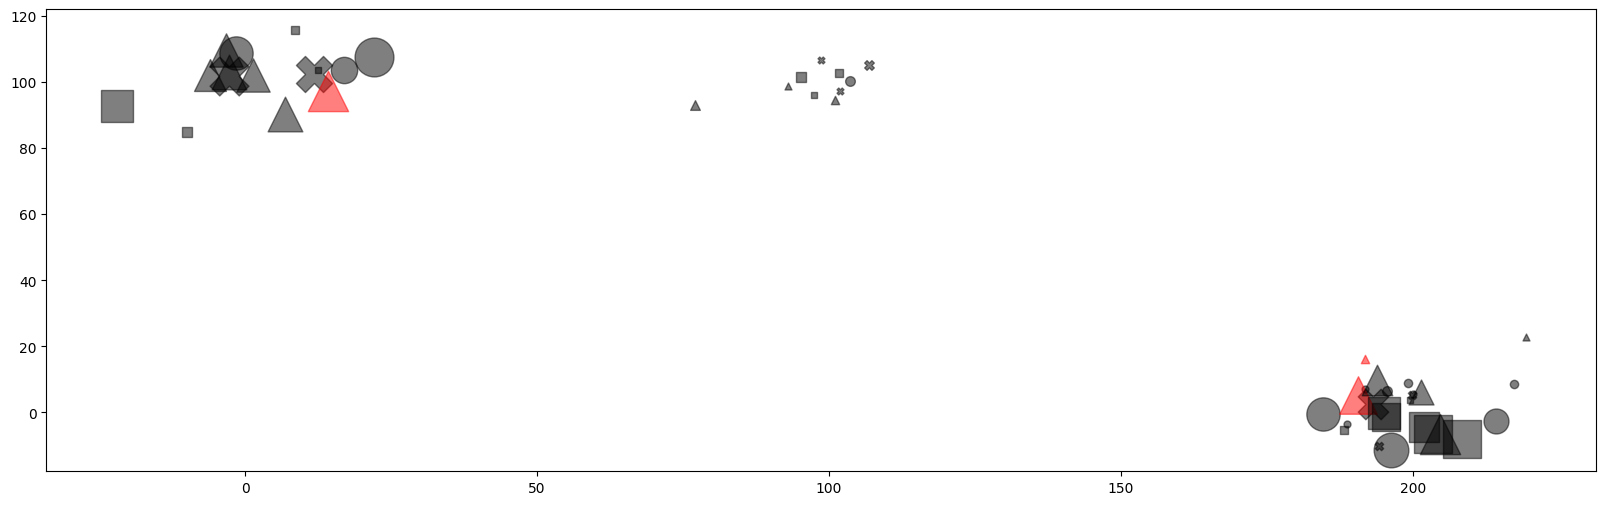

l_selected_sets[i]:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
3  is inside  []
clusters_indexes:  [[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [5, 19, 30]]
number of points:  3


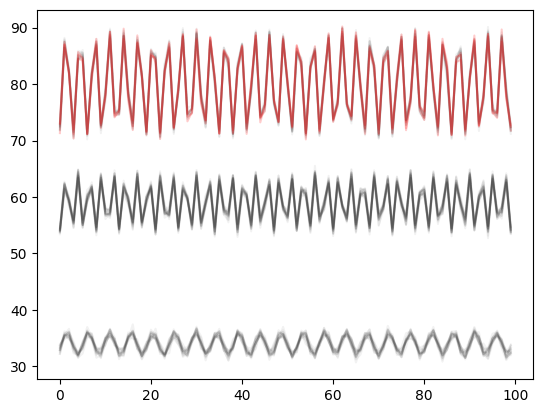

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
4  is a subcluster of  [15, 17, 20]
number of points:  3


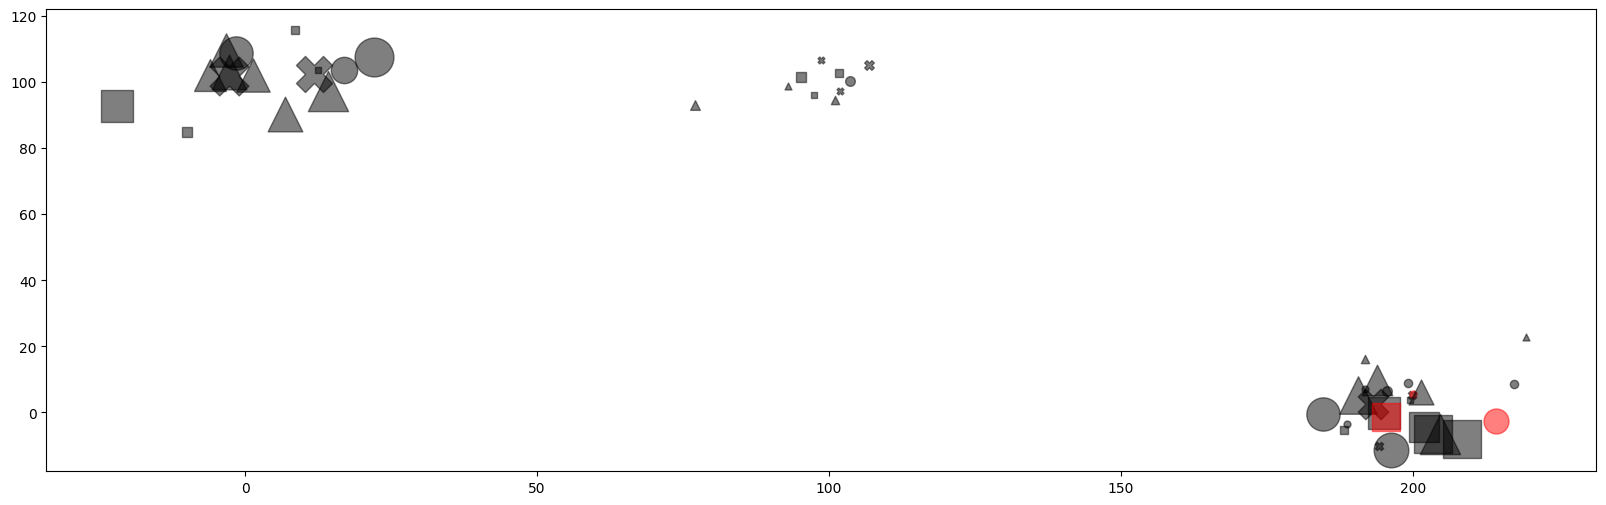

l_selected_sets[i]:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
4  is inside  []
clusters_indexes:  [[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [8, 22, 24]]
number of points:  3


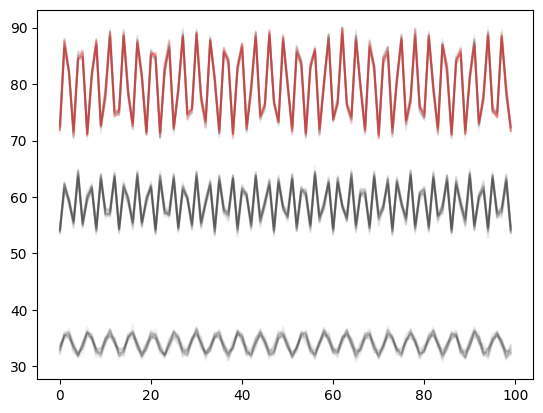

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
5  is a subcluster of  [7, 18, 19, 23]
number of points:  4


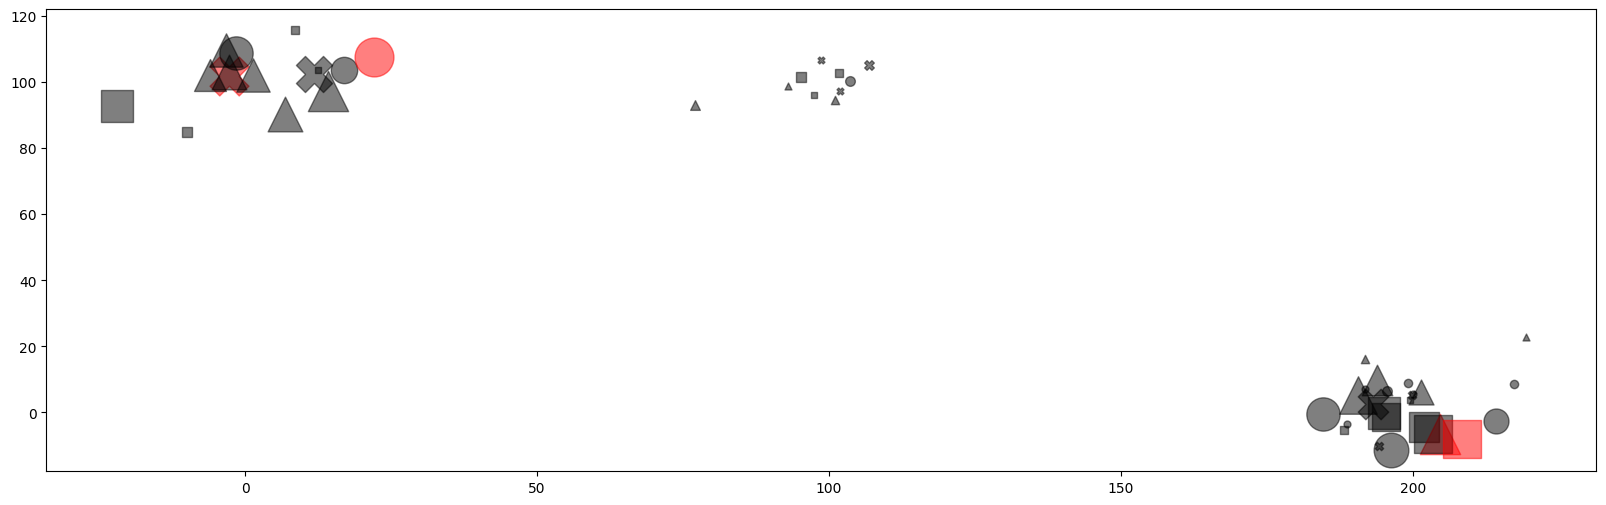

l_selected_sets[i]:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
5  is inside  []
clusters_indexes:  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [17, 20, 27, 28]]
number of points:  4


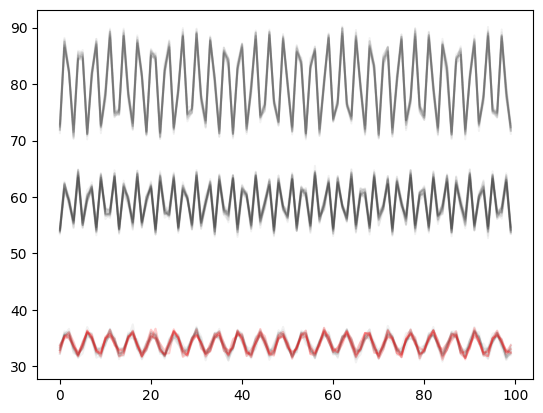

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
6  is a subcluster of  [9, 21, 22, 24]
number of points:  5


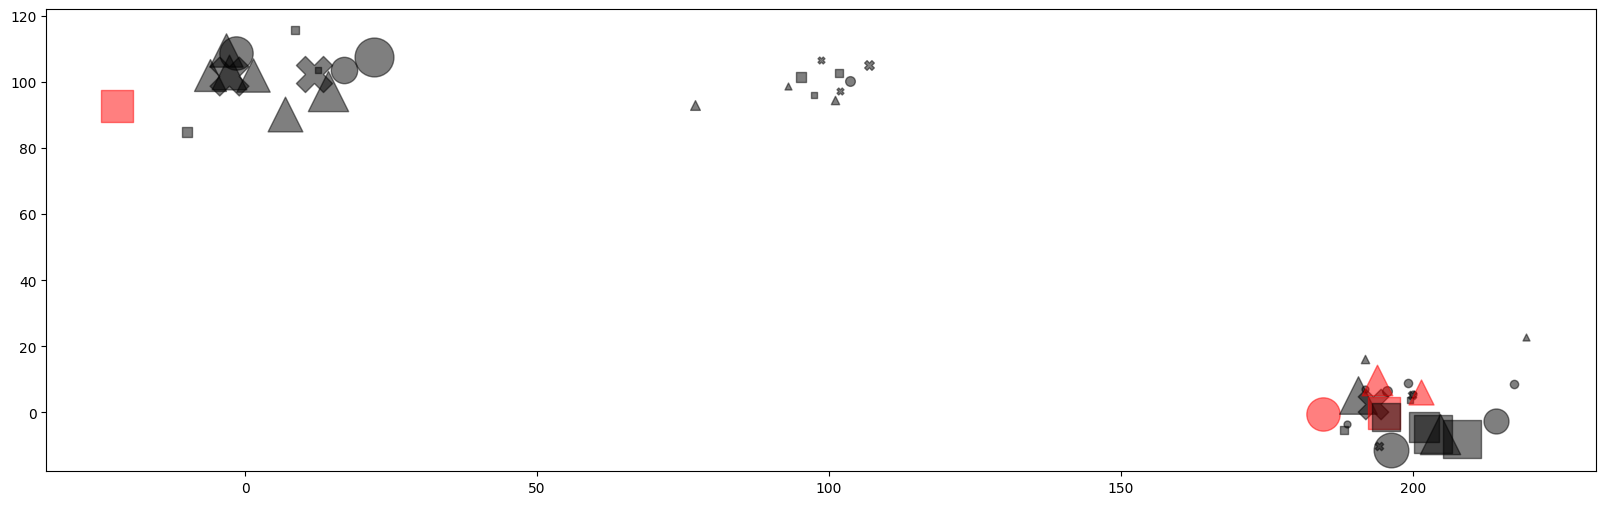

l_selected_sets[i]:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
6  is inside  []
clusters_indexes:  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [15, 16, 21, 23, 36]]
number of points:  5


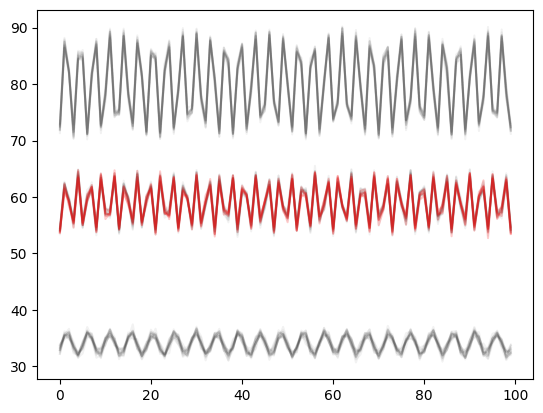

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
7  is a subcluster of  [18, 19, 23]
number of points:  5


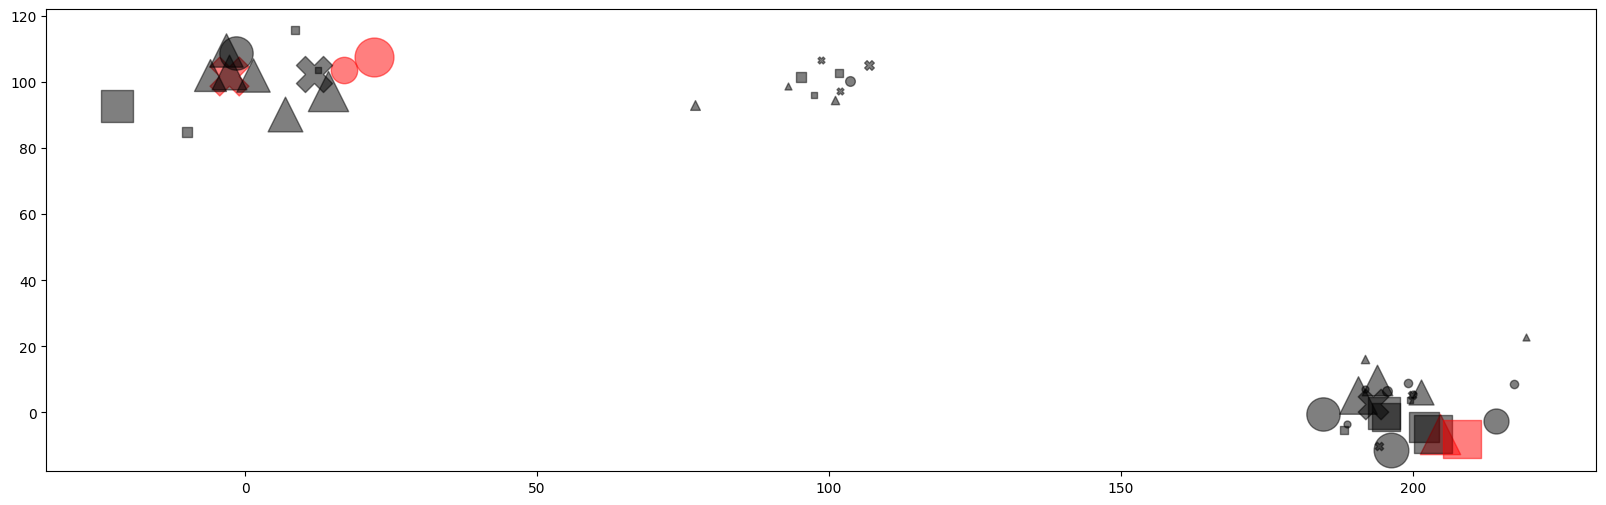

l_selected_sets[i]:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
7  is inside  []
clusters_indexes:  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [17, 20, 25, 27, 28]]
number of points:  5


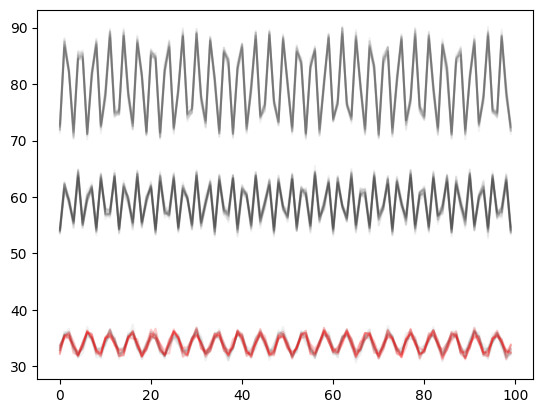

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
8  is a subcluster of  [10, 18, 19, 23]
number of points:  5


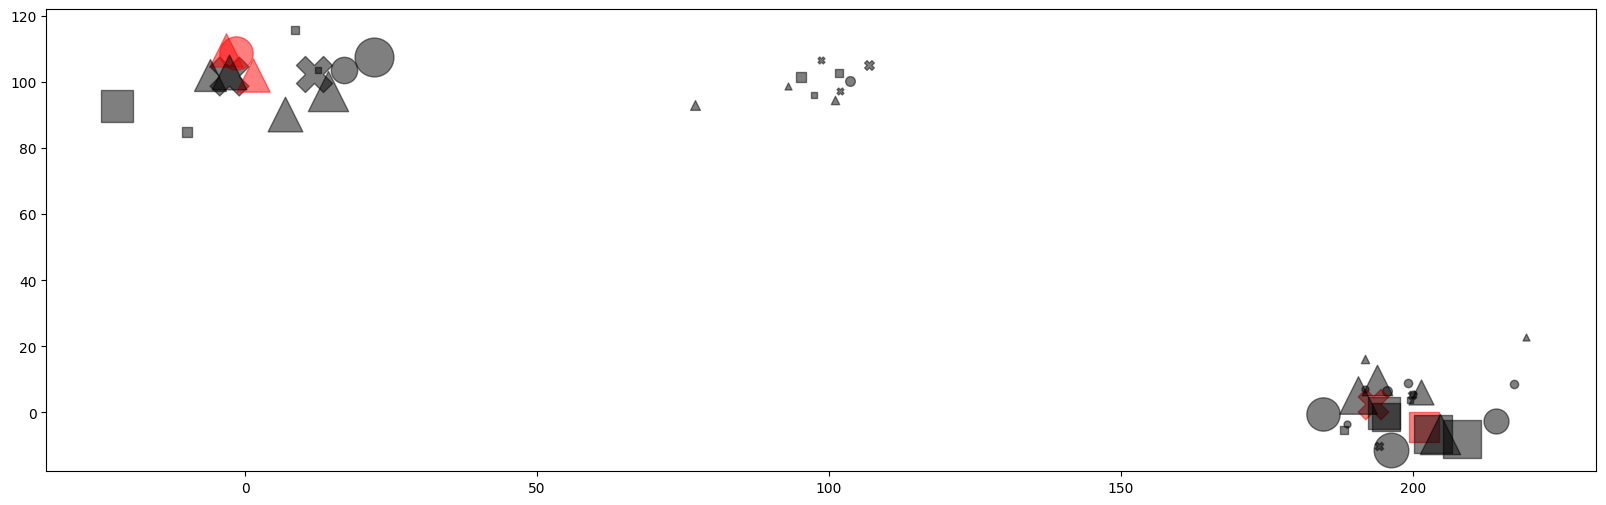

l_selected_sets[i]:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
8  is inside  []
clusters_indexes:  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [12, 14, 29, 31, 33]]
number of points:  5


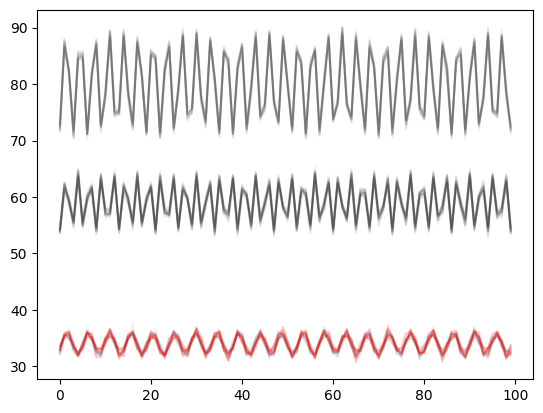

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
9  is a subcluster of  [16, 21, 22, 24]
number of points:  6


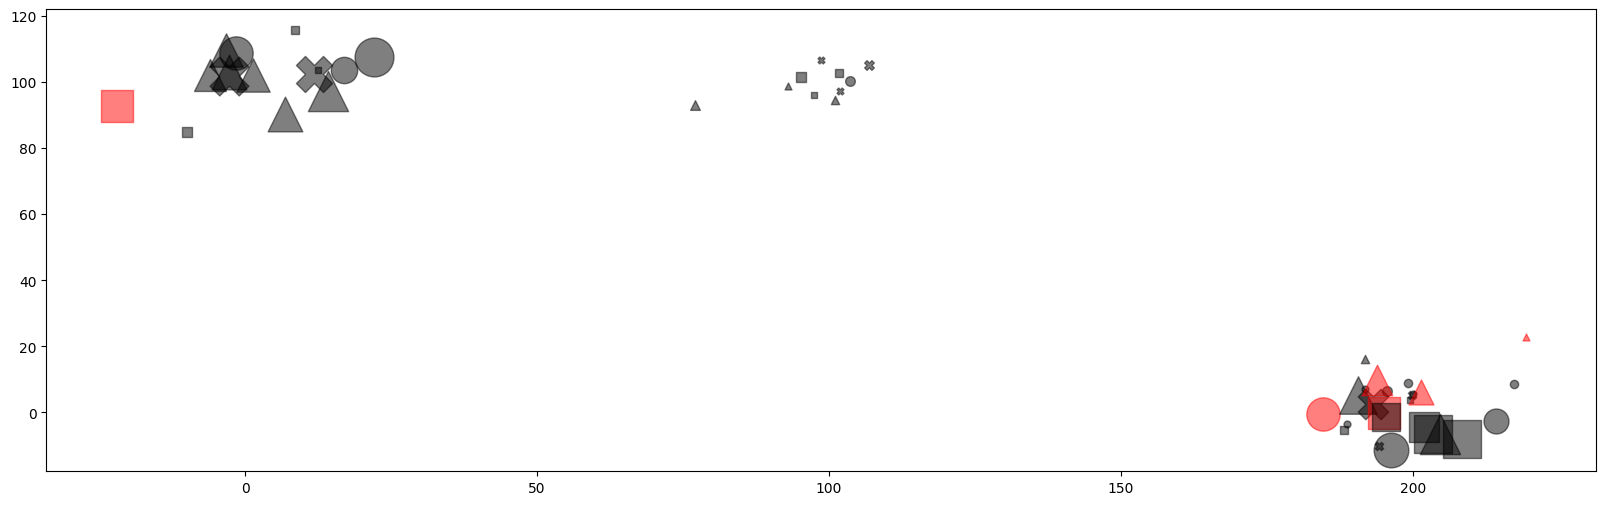

l_selected_sets[i]:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
9  is inside  []
clusters_indexes:  [[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [4, 15, 16, 21, 23, 36]]
number of points:  6


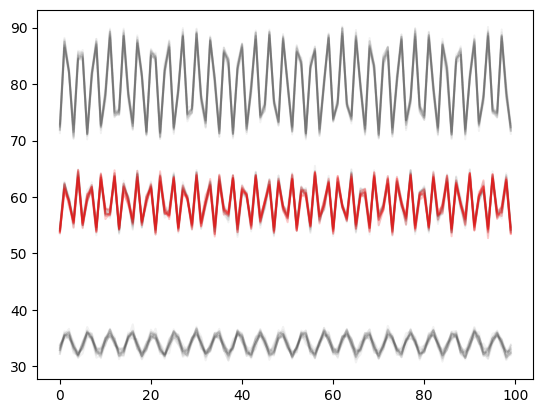

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
10  is a subcluster of  [18, 19, 23]
number of points:  6


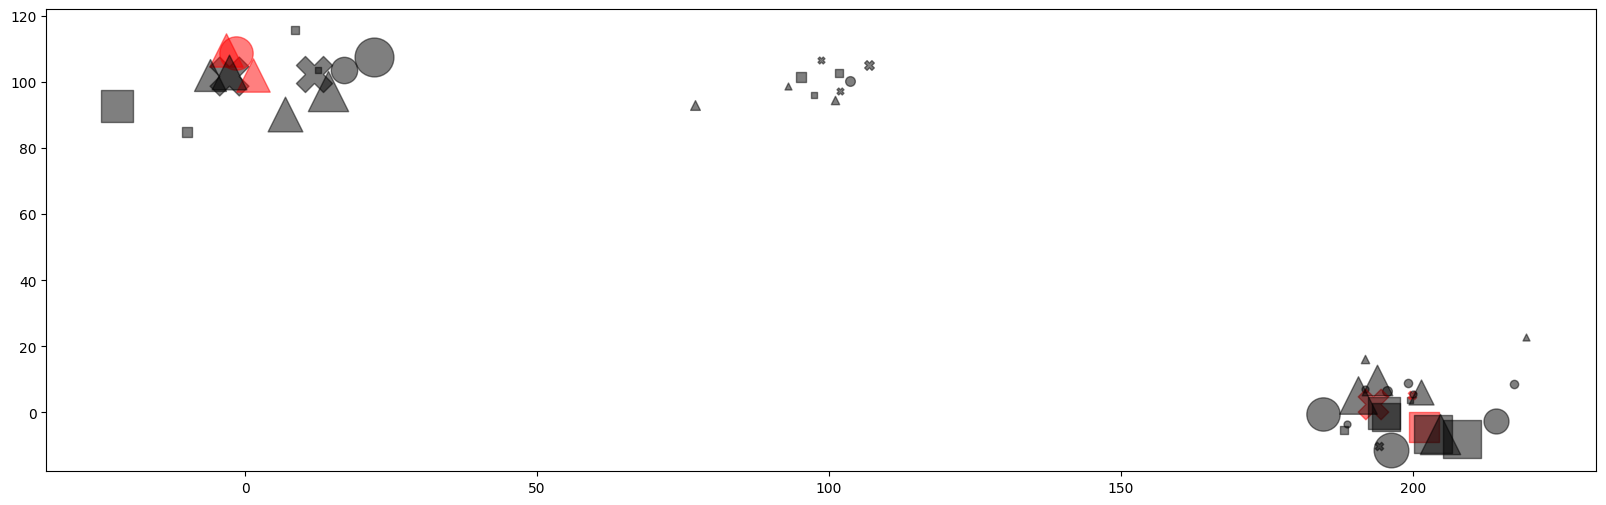

l_selected_sets[i]:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
10  is inside  []
clusters_indexes:  [[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [1, 12, 14, 29, 31, 33]]
number of points:  6


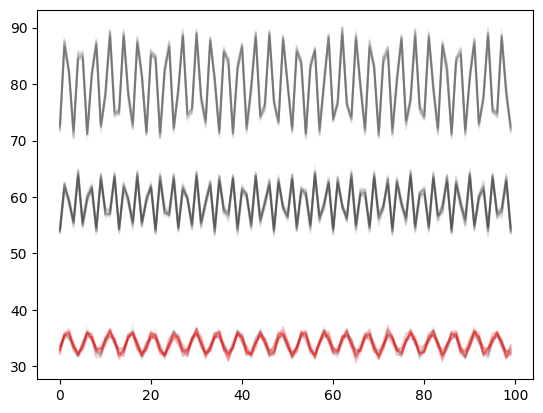

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
11  is a subcluster of  [21, 22, 24]
number of points:  6


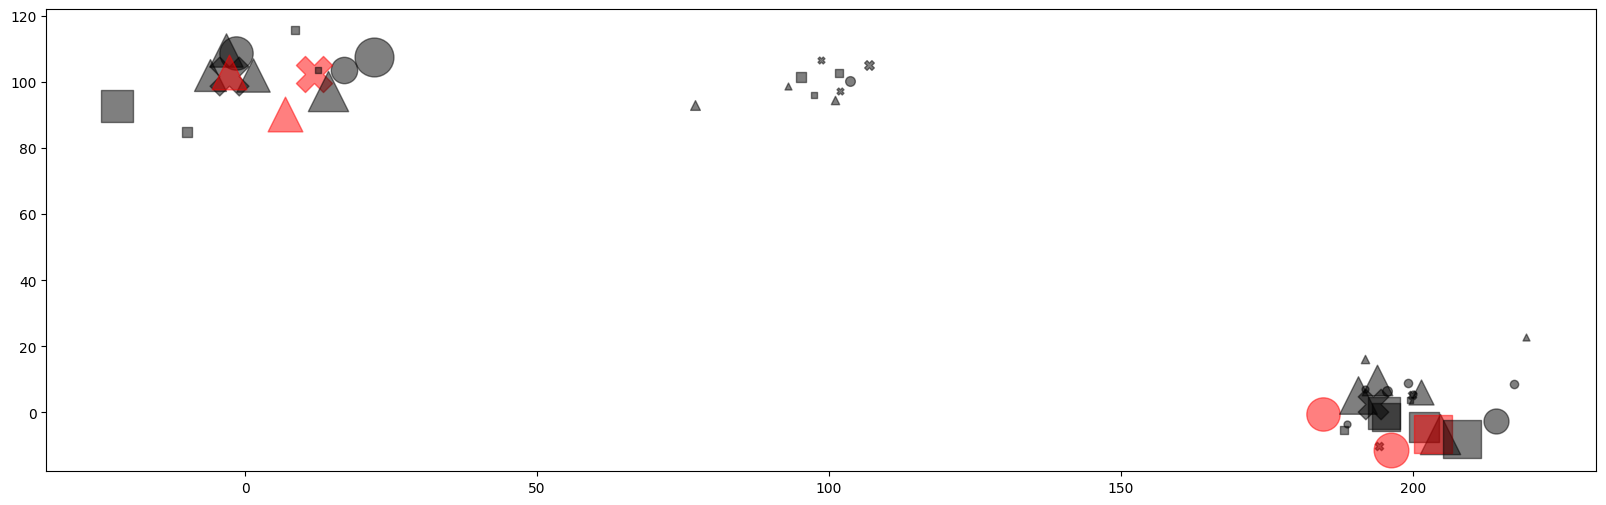

l_selected_sets[i]:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
11  is inside  []
clusters_indexes:  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [13, 16, 18, 26, 32, 35]]
number of points:  6


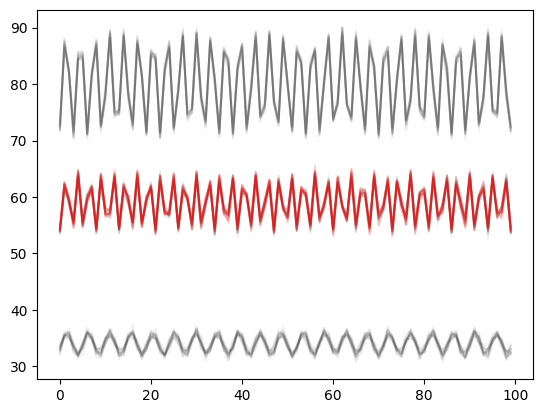

[0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 0.]
12  is a subcluster of  [13, 18, 19, 23]
number of points:  7


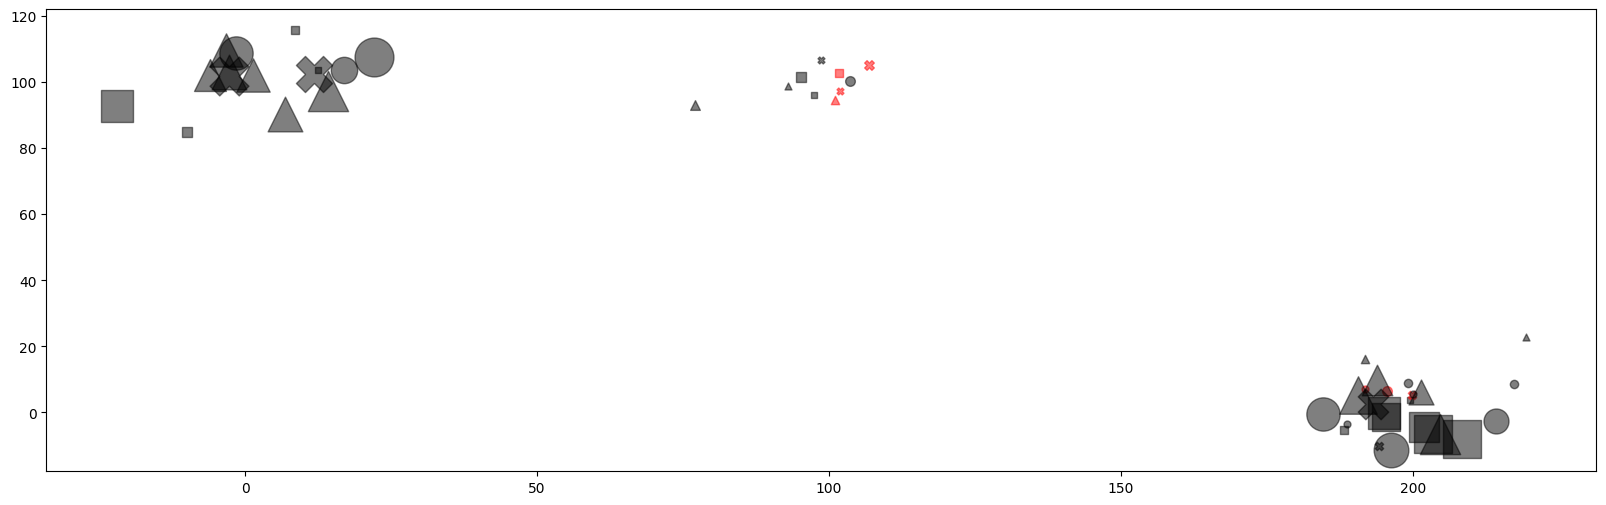

l_selected_sets[i]:  [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 0.]
12  is inside  []
clusters_indexes:  [[0, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 46, 47, 48, 49], [1, 3, 11, 42, 43, 44, 45]]
number of points:  7


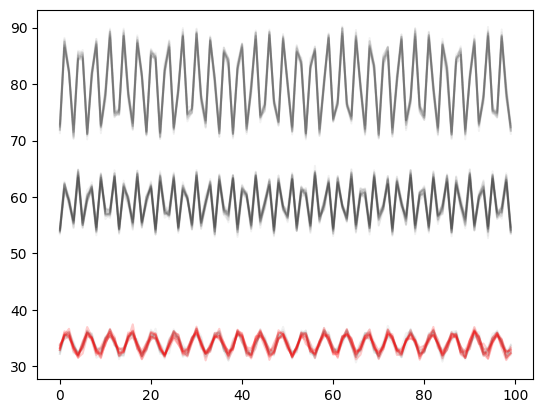

[0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 0.]
13  is a subcluster of  [18, 19, 23]
number of points:  8


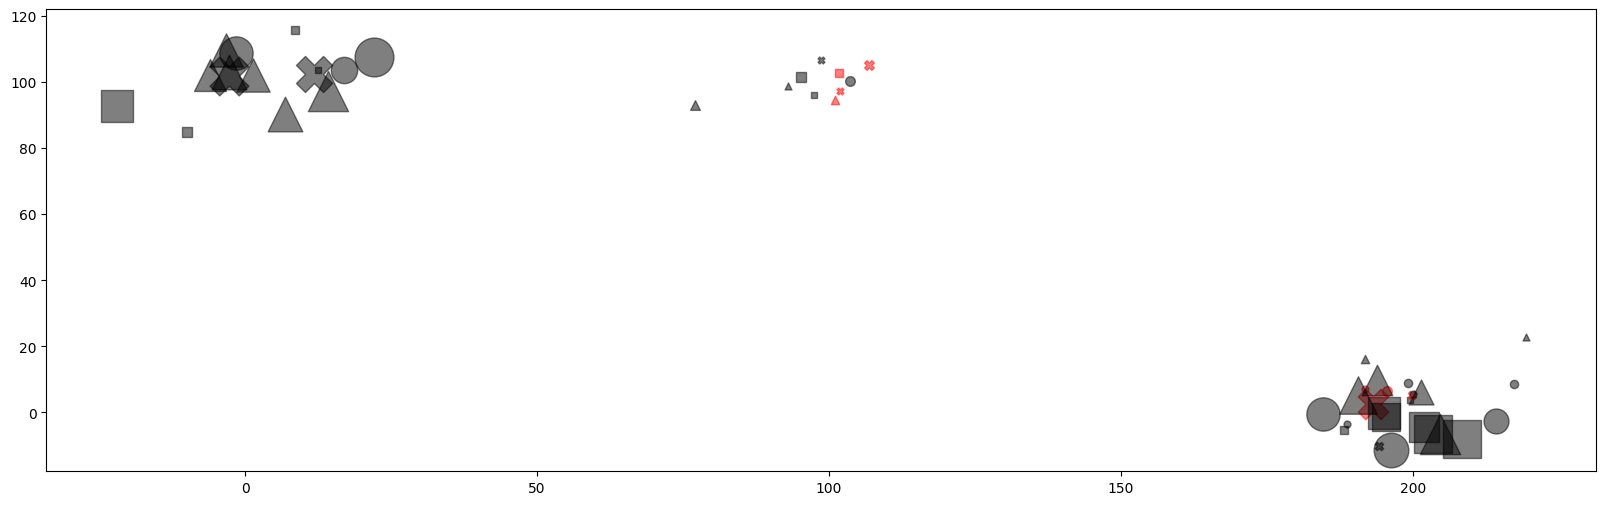

l_selected_sets[i]:  [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 0.]
13  is inside  []
clusters_indexes:  [[0, 2, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 46, 47, 48, 49], [1, 3, 11, 12, 42, 43, 44, 45]]
number of points:  8


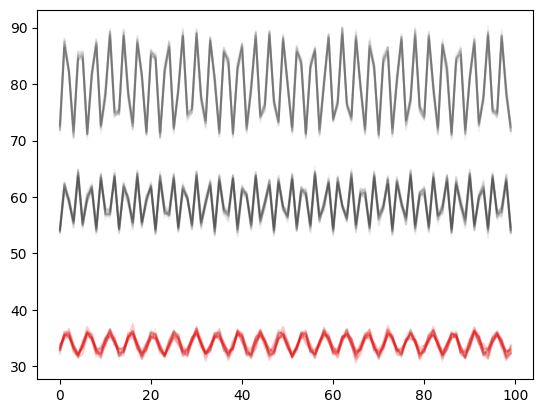

[1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]
14  is a subcluster of  [16, 21, 22, 24]
number of points:  9


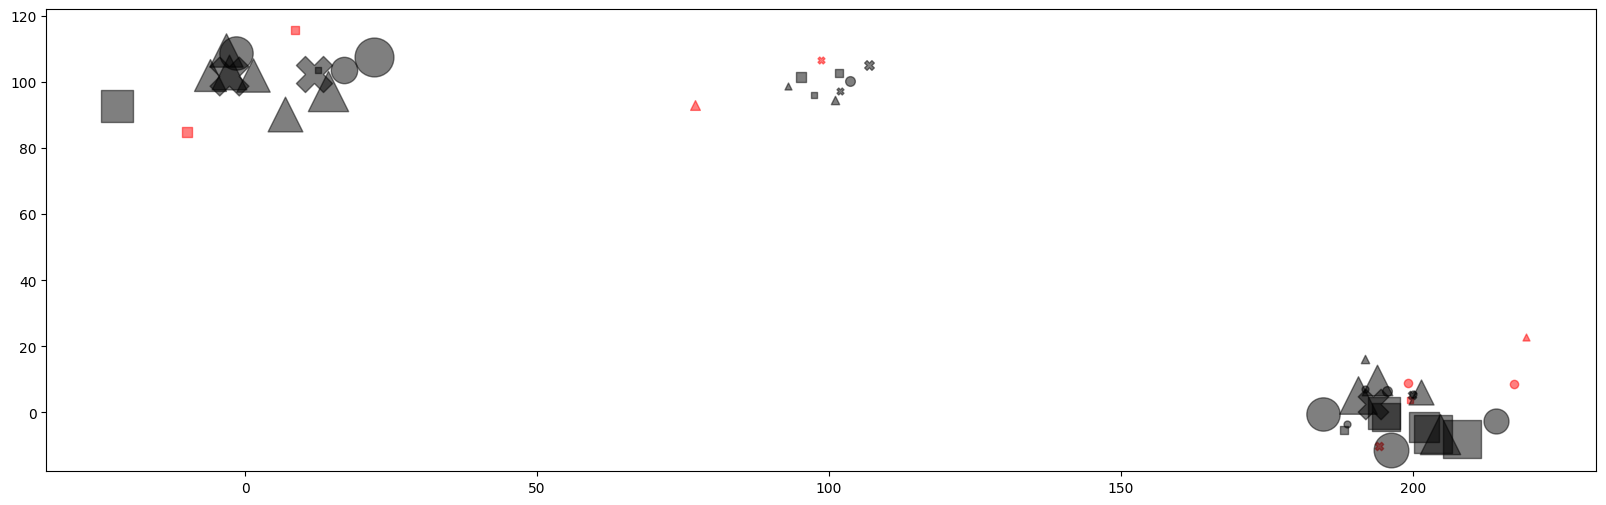

l_selected_sets[i]:  [1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]
14  is inside  []
clusters_indexes:  [[1, 2, 3, 5, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 41, 42, 43, 44, 45, 46, 47, 48], [0, 4, 6, 7, 10, 37, 38, 40, 49]]
number of points:  9


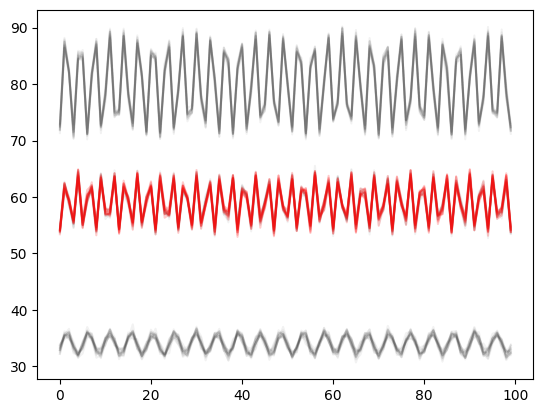

[0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 0.]
15  is a subcluster of  [17, 20]
number of points:  9


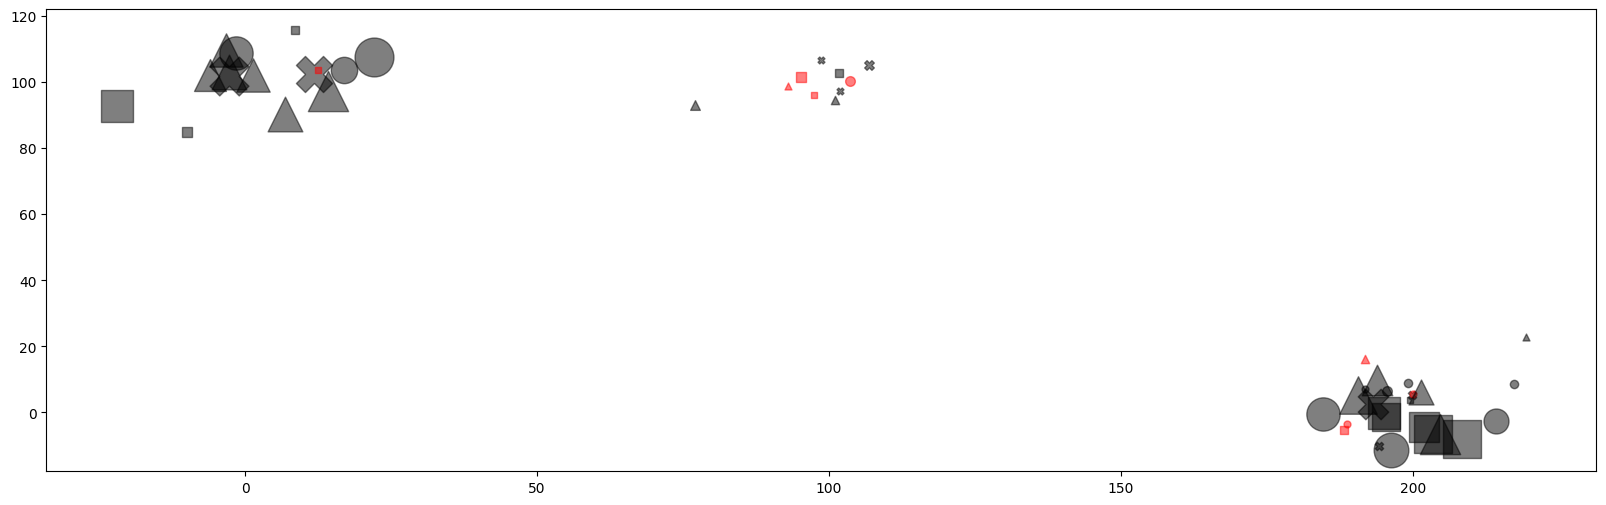

l_selected_sets[i]:  [0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 0.]
15  is inside  []
clusters_indexes:  [[0, 1, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 45, 49], [2, 5, 8, 9, 39, 41, 46, 47, 48]]
number of points:  9


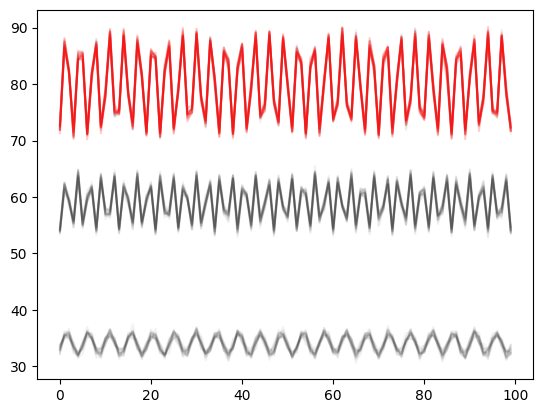

[1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]
16  is a subcluster of  [21, 22, 24]
number of points:  10


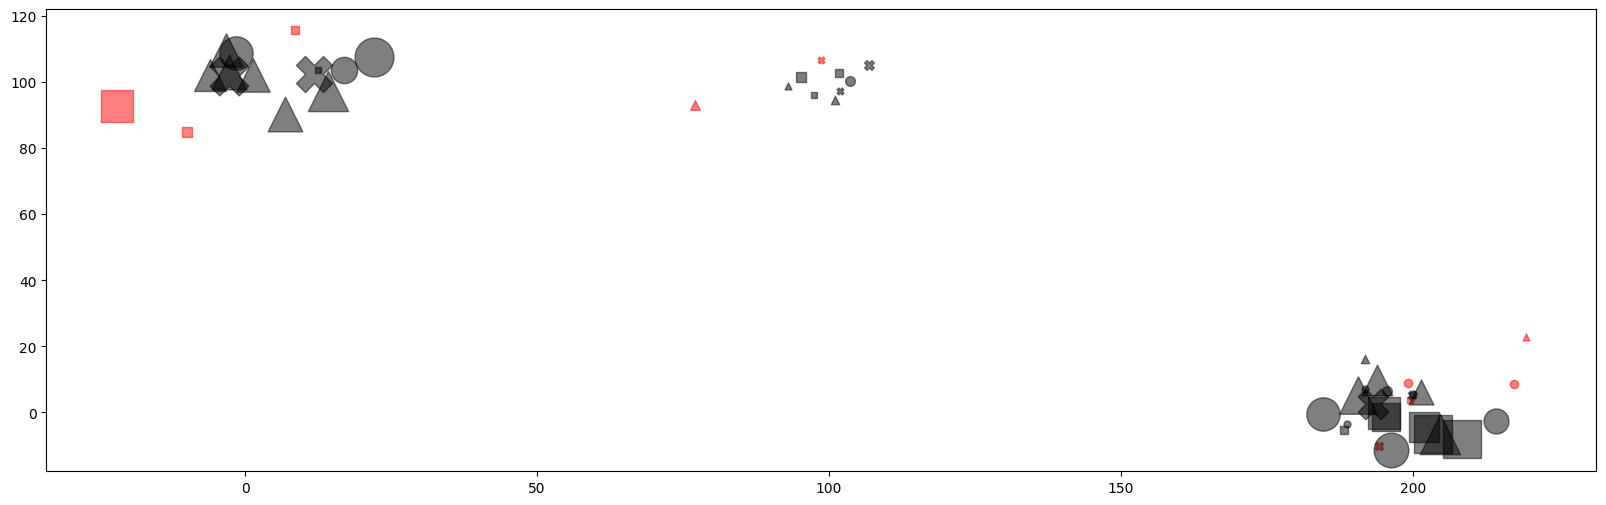

l_selected_sets[i]:  [1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]
16  is inside  []
clusters_indexes:  [[1, 2, 3, 5, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 41, 42, 43, 44, 45, 46, 47, 48], [0, 4, 6, 7, 10, 36, 37, 38, 40, 49]]
number of points:  10


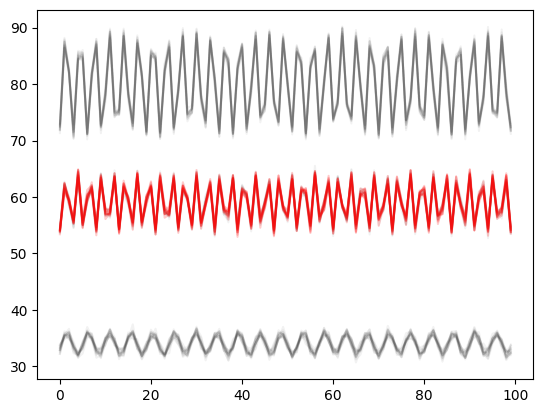

[0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 0.]
17  is a subcluster of  [20]
number of points:  10


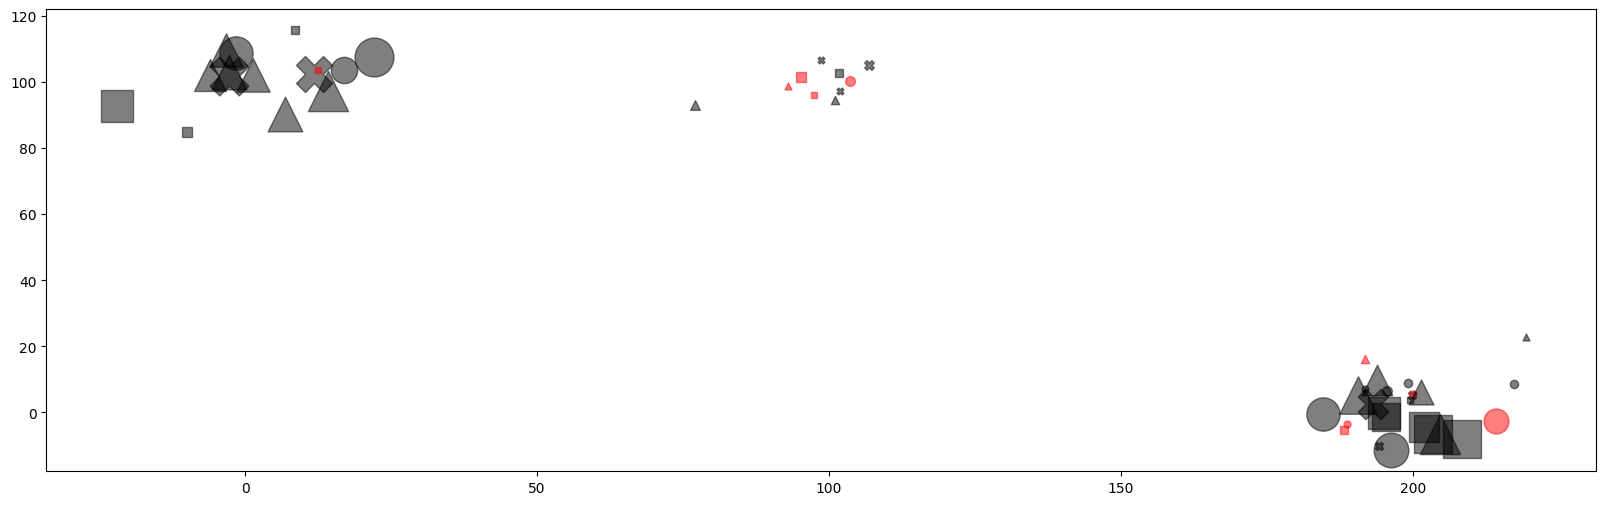

l_selected_sets[i]:  [0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 0.]
17  is inside  []
clusters_indexes:  [[0, 1, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 45, 49], [2, 5, 8, 9, 24, 39, 41, 46, 47, 48]]
number of points:  10


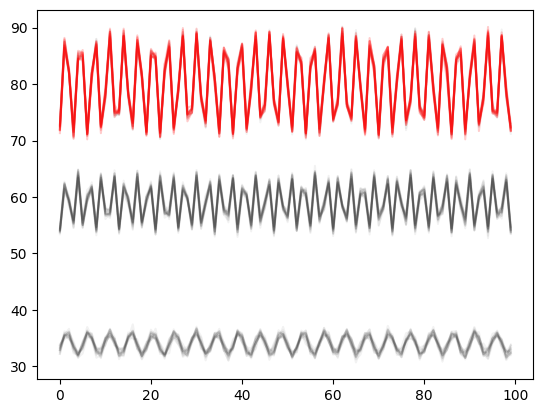

[0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 0.]
18  is a subcluster of  [19, 23]
number of points:  11


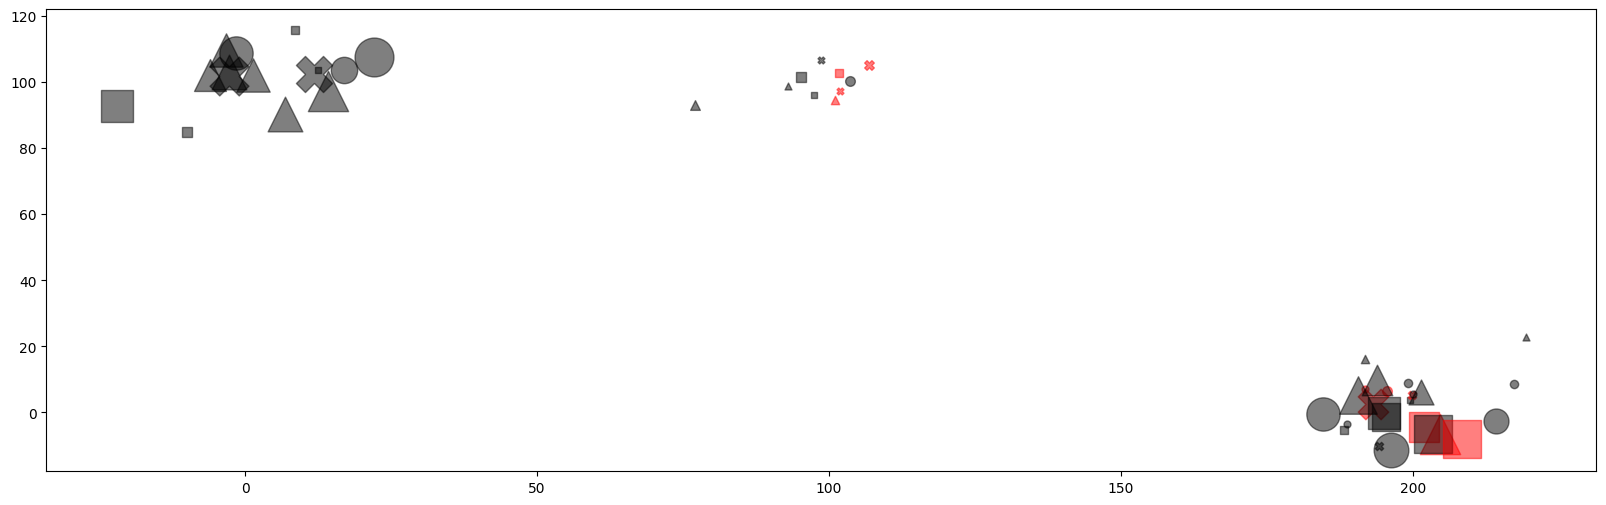

l_selected_sets[i]:  [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 0.]
18  is inside  []
clusters_indexes:  [[0, 2, 4, 5, 6, 7, 8, 9, 10, 13, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 46, 47, 48, 49], [1, 3, 11, 12, 14, 17, 20, 42, 43, 44, 45]]
number of points:  11


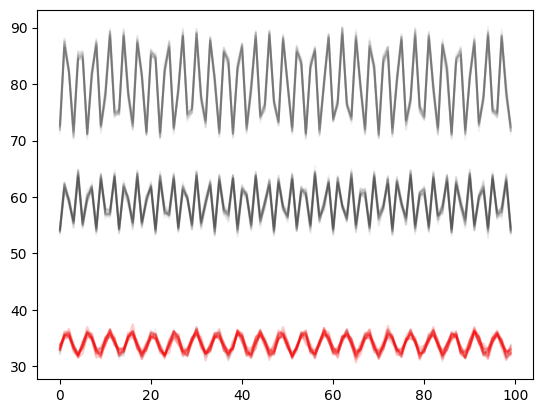

[0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
19  is a subcluster of  [23]
number of points:  13


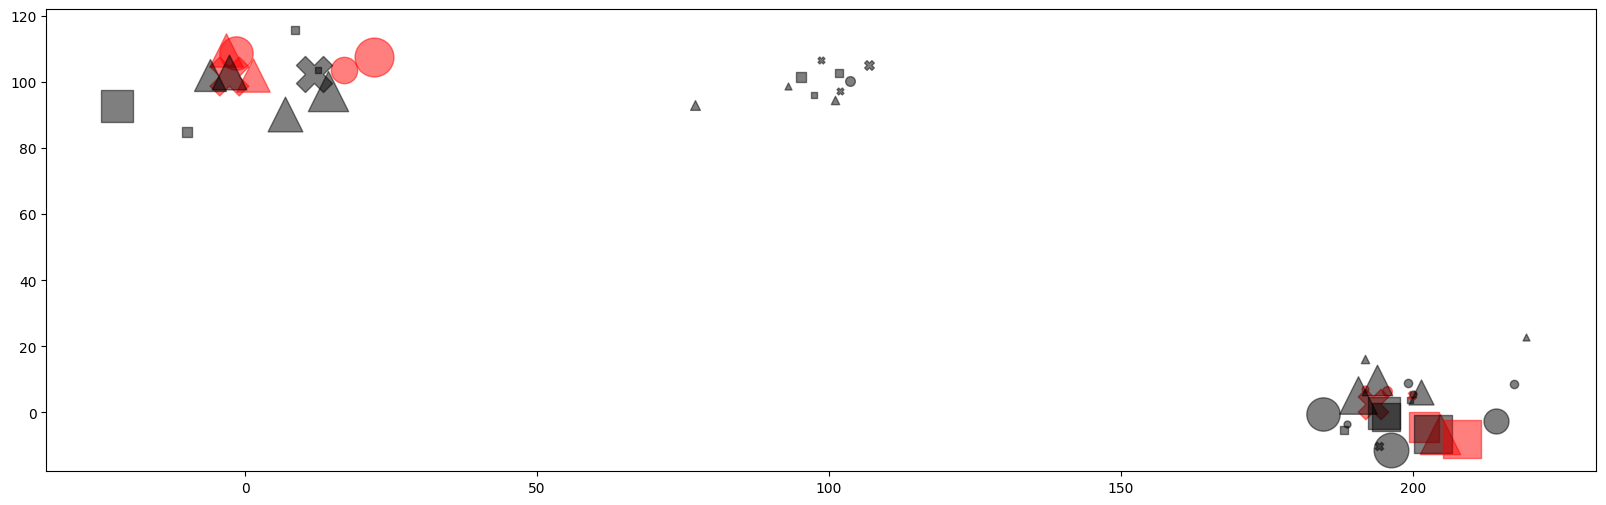

l_selected_sets[i]:  [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
19  is inside  []
clusters_indexes:  [[0, 2, 4, 5, 6, 7, 8, 9, 10, 13, 15, 16, 18, 19, 21, 22, 23, 24, 26, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [1, 3, 11, 12, 14, 17, 20, 25, 27, 28, 29, 31, 33]]
number of points:  13


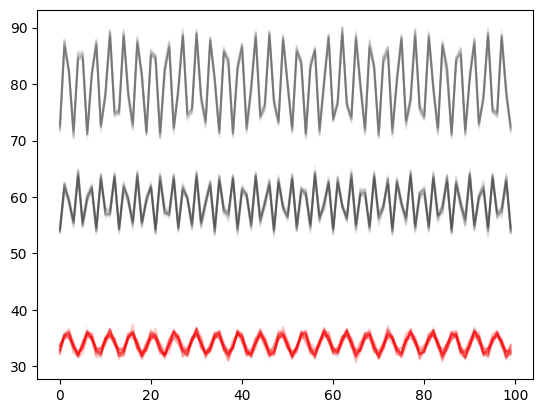

[0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 0.]
20 is a cluster
number of points:  14


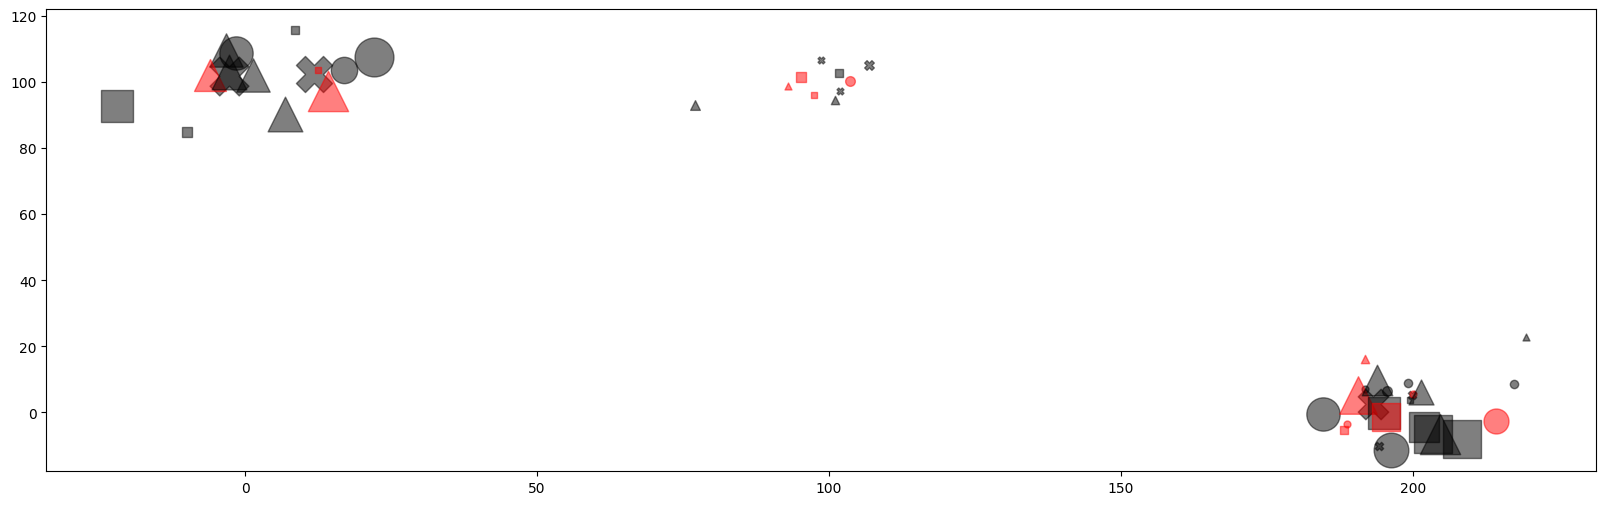

l_selected_sets[i]:  [0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 0.]
20  is inside  []
clusters_indexes:  [[0, 1, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 23, 25, 26, 27, 28, 29, 31, 32, 33, 35, 36, 37, 38, 40, 42, 43, 44, 45, 49], [2, 5, 8, 9, 19, 22, 24, 30, 34, 39, 41, 46, 47, 48]]
number of points:  14


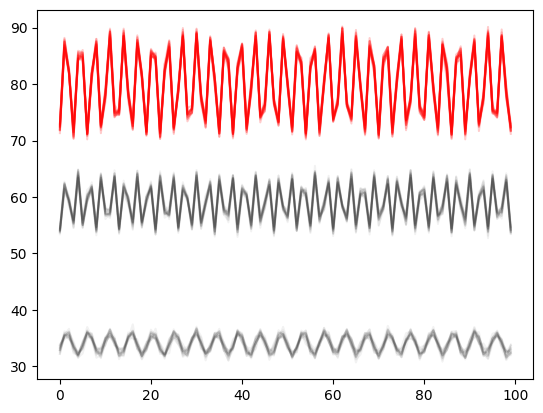

[1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
21  is a subcluster of  [22, 24]
number of points:  15


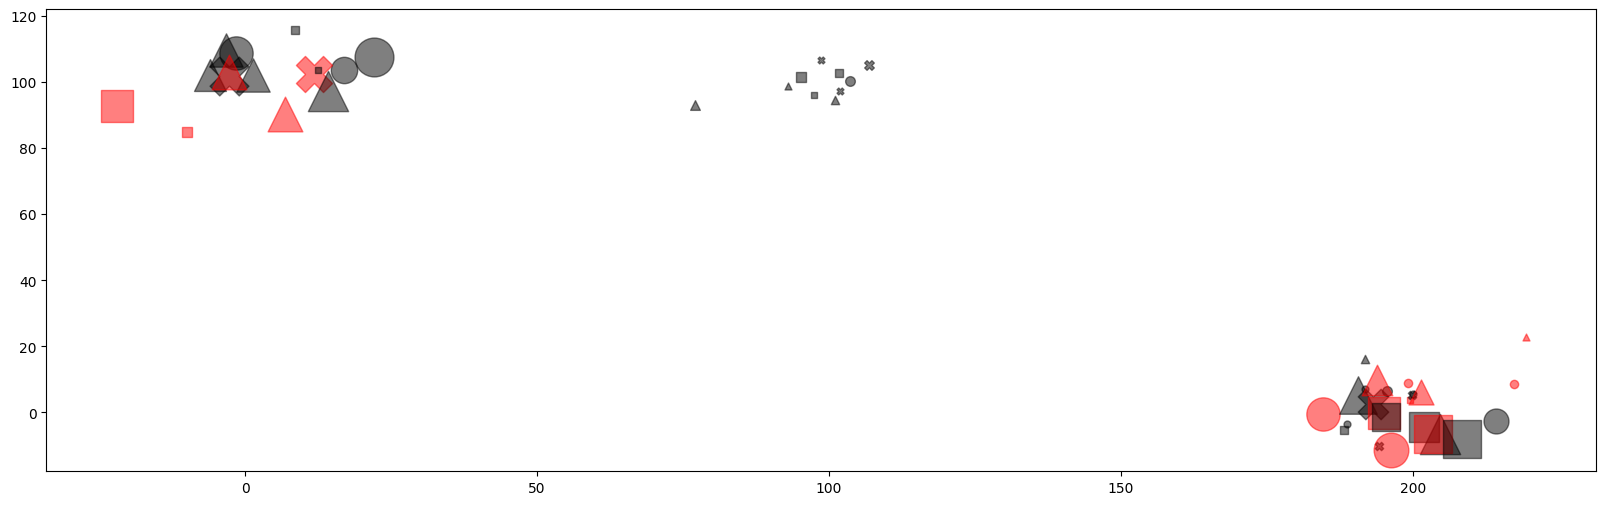

l_selected_sets[i]:  [1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
21  is inside  []
clusters_indexes:  [[1, 2, 3, 5, 8, 9, 10, 11, 12, 14, 17, 19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [0, 4, 6, 7, 13, 15, 16, 18, 21, 23, 26, 32, 35, 36, 37]]
number of points:  15


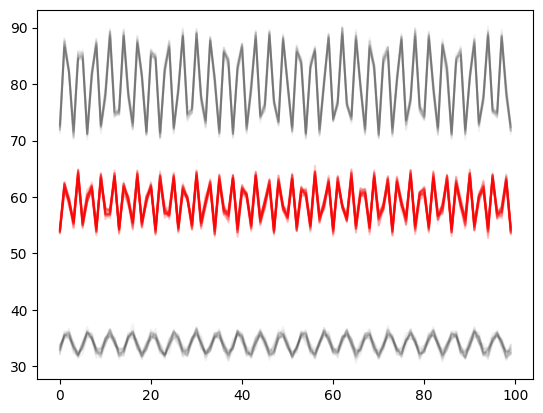

[1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
22  is a subcluster of  [24]
number of points:  17


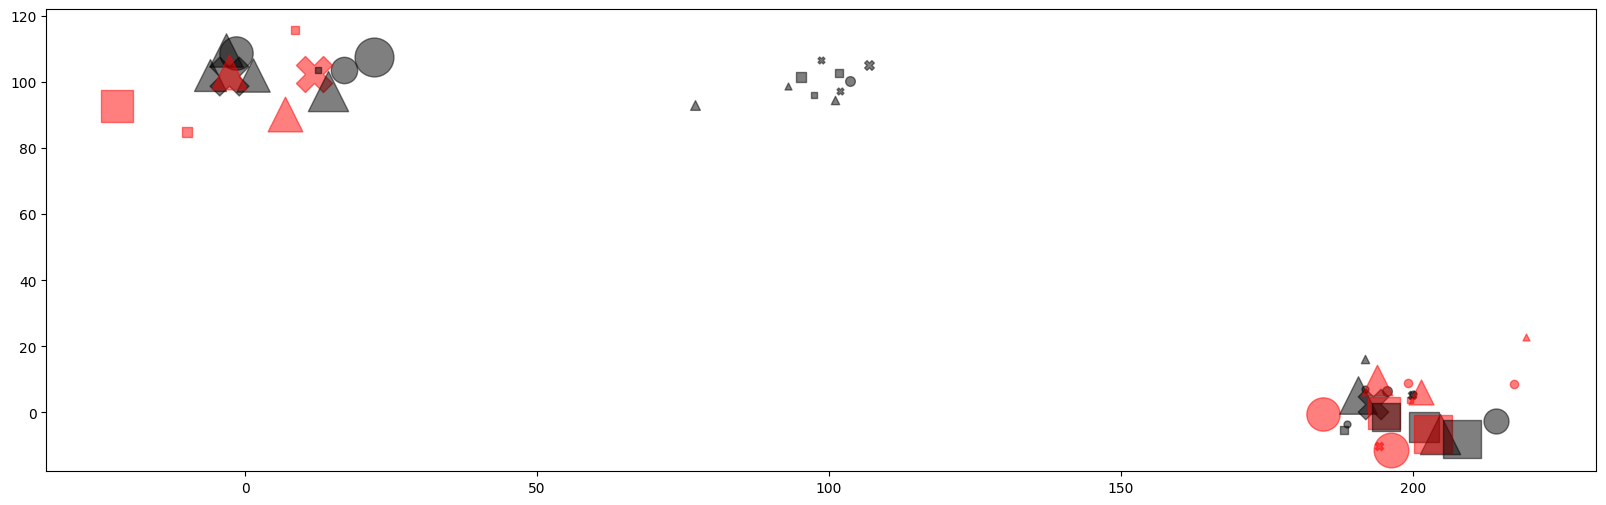

l_selected_sets[i]:  [1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
22  is inside  []
clusters_indexes:  [[1, 2, 3, 5, 8, 9, 11, 12, 14, 17, 19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 33, 34, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [0, 4, 6, 7, 10, 13, 15, 16, 18, 21, 23, 26, 32, 35, 36, 37, 38]]
number of points:  17


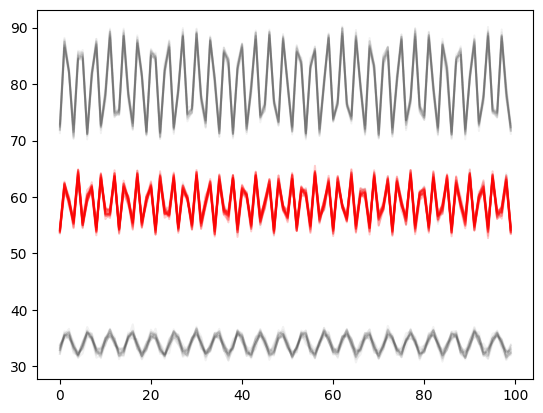

[0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 0.]
23 is a cluster
number of points:  17


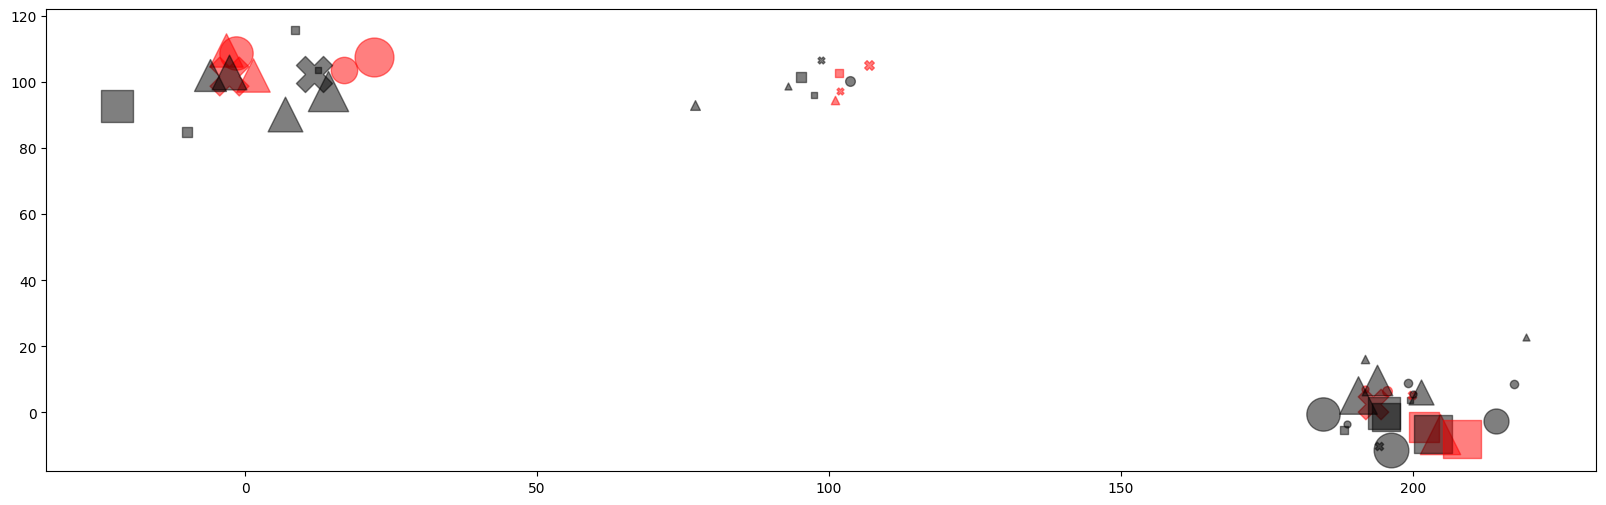

l_selected_sets[i]:  [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 0.]
23  is inside  []
clusters_indexes:  [[0, 2, 4, 5, 6, 7, 8, 9, 10, 13, 15, 16, 18, 19, 21, 22, 23, 24, 26, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 46, 47, 48, 49], [1, 3, 11, 12, 14, 17, 20, 25, 27, 28, 29, 31, 33, 42, 43, 44, 45]]
number of points:  17


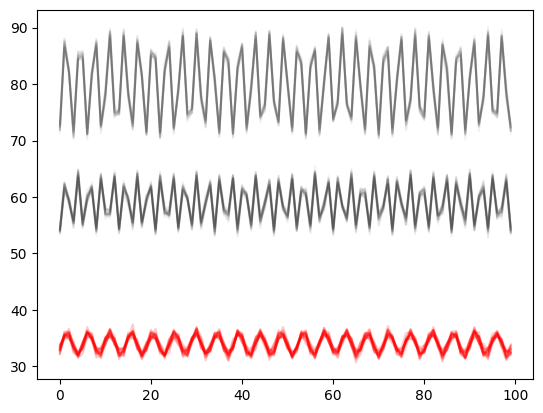

[1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]
24 is a cluster
number of points:  19


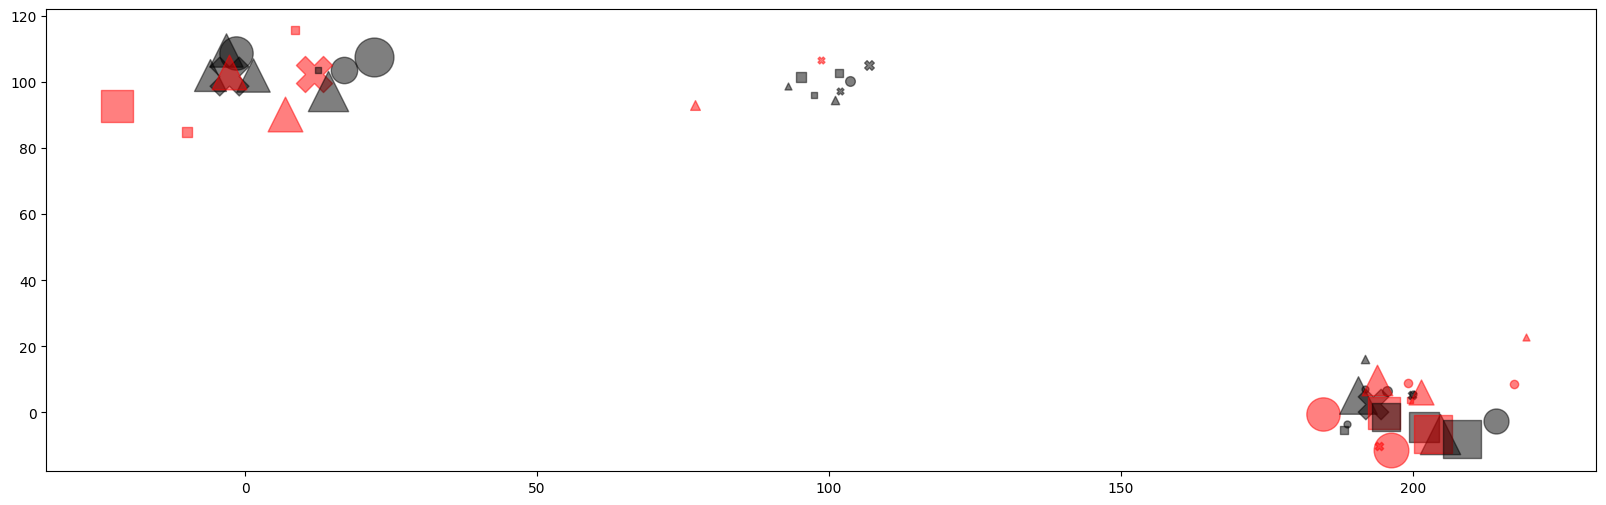

l_selected_sets[i]:  [1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]
24  is inside  []
clusters_indexes:  [[1, 2, 3, 5, 8, 9, 11, 12, 14, 17, 19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 33, 34, 39, 41, 42, 43, 44, 45, 46, 47, 48], [0, 4, 6, 7, 10, 13, 15, 16, 18, 21, 23, 26, 32, 35, 36, 37, 38, 40, 49]]
number of points:  19


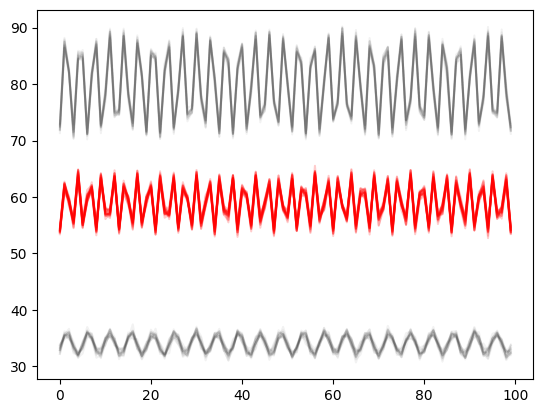

In [27]:
plot_hierarchy(a_center, b_center, c_center, a_size, b_size, c_size, a_dispersion, b_dispersion, c_dispersion,
                  radius_coeff, threshold_coeff, closest_coeff, square_length_coeff, initial_set_size)